In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=5
%env DWAVE_API_TOKEN=DEV-1ba72787de429d2af12464f7753c10b9ff6945ad
%config InlineBackend.figure_format = 'retina'
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: DWAVE_API_TOKEN=DEV-1ba72787de429d2af12464f7753c10b9ff6945ad
Wed Nov 20 23:29:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:1B:00.0 Off |                  Off |
| 30%   32C    P8             22W /  300W |     582MiB /  49140MiB |      0%      Default |
|                                       

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

import sys
import os
import getpass

upper_dir = 'SC_VAE'
# Path to where your CaloQVAE dir is
os.chdir('/home/' + getpass.getuser() + f'/{upper_dir}' + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + f'/{upper_dir}' + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + f'/{upper_dir}/')

#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[23:29:42.290] INFO   CaloQVAE                                          Willkommen!
[23:29:42.292] INFO   CaloQVAE                                          Loading configuration.


In [3]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/fast_scratch_1/caloqvae/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/fast_scratch_1/caloqvae/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

2024-11-20 23:29:48,494 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[23:29:48.494] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [4]:
# Load or reload config files
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="../configs")

hydra.initialize()

In [5]:
# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/usr/local/lib/python3.10/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[23:29:50.080] ERROR  wandb.jupyter                                     Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
[23:29:51.536] INFO   data.dataManager                                  Loading Data
[23:30:12.452] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f73683dd780>: 80000 events, 625 batches
[23:30:12.454] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f72afb9c310>: 10000 events, 10 batches
[23:30:12.455] INFO   data.dataManager                                  <torch.utils.data.dataload

Initializing NetworkV3


In [6]:
dev = torch.device("cuda:4")
# dev = "cuda:{0}".format(config.gpu_list[0])
wandb.watch(model)
engine=instantiate(config.engine, config)
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[23:30:19.006] INFO   wandb                                             Watching
/home/blazerjia/.local/lib/python3.10/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[23:30:21.815] INFO   engine.engineAtlas                                Setting up engine Atlas.
[23:30:21.816] INFO   engine.engineCaloV3                               Setting up engine Calo.
[23:30:21.817] INFO   engine.engine                                     Setting up default engine.


In [7]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            print(local_module_keys)
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

In [8]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[23:30:43.227] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f72afd02fe0>: 80000 events, 625 batches
[23:30:43.229] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f72afd02e90>: 10000 events, 10 batches
[23:30:43.230] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f72afd02ce0>: 10000 events, 10 batches


In [9]:
# chip 6.4 is pegasus
engine.model._qpu_sampler.properties["chip_id"]

'Advantage_system4.1'

In [10]:
# Original run path
# run_path = "/fast_scratch_1/caloqvae/blazerjia/wandb/run-20240705_190726-t13cwqm8/files/AtlasConditionalQVAEv2_atlas_default_150.pth"
#first try:
# run_path = '/fast_scratch_1/caloqvae/blazerjia/wandb/run-20240729_190648-TZi58i6R/files/AtlasConditionalQVAEv2_atlas_default_920.pth'
#second try:
run_path = '/fast_scratch_1/caloqvae/blazerjia/wandb/run-20241120_104359-EzKq7swx/files/AtlasConditionalQVAE3D_atlas_default_latest.pth'

# run_path = '/fast_scratch_1/caloqvae/dsogutlu/wandb/run-20240930_172648-2ytiongh/files/AtlasConditionalQVAE3DHD_atlas_default_150.pth'

# run_path = '/fast_scratch_1/caloqvae/blazerjia/wandb/run-20240927_165539-ucjwxocc/files/AtlasConditionalQVAE3D_atlas_default_150.pth'
modelname = 'denim-smoke-166'
datascaled = 'reduced'
with open("/fast_scratch_1/caloqvae/blazerjia/wandb/run-20241008_003547-fH7vDJ2R/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False
    
arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
modelCreator.load_state(run_path, dev)
engine.model.eval();

[23:30:43.591] INFO   models.modelCreator                               Loading state
[23:30:43.669] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/blazerjia/wandb/run-20241120_104359-EzKq7swx/files/AtlasConditionalQVAE3D_atlas_default_latest.pth


AtlasConditionalQVAE3D
electron-ds2
False True
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [11]:
# model.decoder

In [12]:
# old = torch.load('/fast_scratch_1/caloqvae/QVAE/run-20240609_163342-ct/files/GumBoltAtlasPCRBMCNN_atlas_default_latest.pth')

In [13]:
# old["decoder"]["_layers.6.weight"].shape

In [14]:
# en_labels = []

xtarget_samples = []
xrecon_samples = []
xgen_samples = []
xgen_samples_qpu = []
n_samples4_qpu = 200
reducedata = True
# xrecon_samples_2 = []
R = 1e-7

# labelstarget_samples = []
# labelsrecon_samples = []
entarget_samples = []
cond = True
with torch.no_grad():
    for xx in test_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        ###############################################
        # true_energy = true_energy[:n_samples4_qpu,:]
        # in_data = in_data[:n_samples4_qpu,:]
        ##############################################
        # print(in_data.shape)
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        fwd_output = engine.model((in_data, true_energy), False)
        if reducedata:
            in_data = engine._reduceinv(in_data, true_energy, R=R)
            recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
            engine._model.sampler._batch_size = true_energy.shape[0]
            if cond:
                sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy, num_samples=1, thrsh=30, beta=1/beta0)
            else:
                sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
            # sample_data_qpu = engine._reduceinv(sample_data_qpu, sample_energies_qpu, R=R)
        elif scaled:
            in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
            recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
            # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
            # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
            engine._model.sampler._batch_size = true_energy.shape[0]
            
            if True:
                sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy[:100,:], num_samples=1, thrsh=30, beta=1/beta0)
            else:
                sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
            # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
        else:
            in_data = in_data.detach().cpu()*1000
            recon_data = fwd_output.output_activations.detach().cpu()*1000
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
            sample_data = sample_data.detach().cpu()*1000


        xtarget_samples.append(in_data.detach().cpu())
        xrecon_samples.append( recon_data.detach().cpu())
        xgen_samples.append( sample_data.detach().cpu())
        # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
        entarget_samples.append(true_energy.detach().cpu())

        # xrecon_samples_2.append( recon_data_2.detach().cpu())
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
# xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

# xrecon_samples_2 = torch.cat(xrecon_samples_2, dim=0)

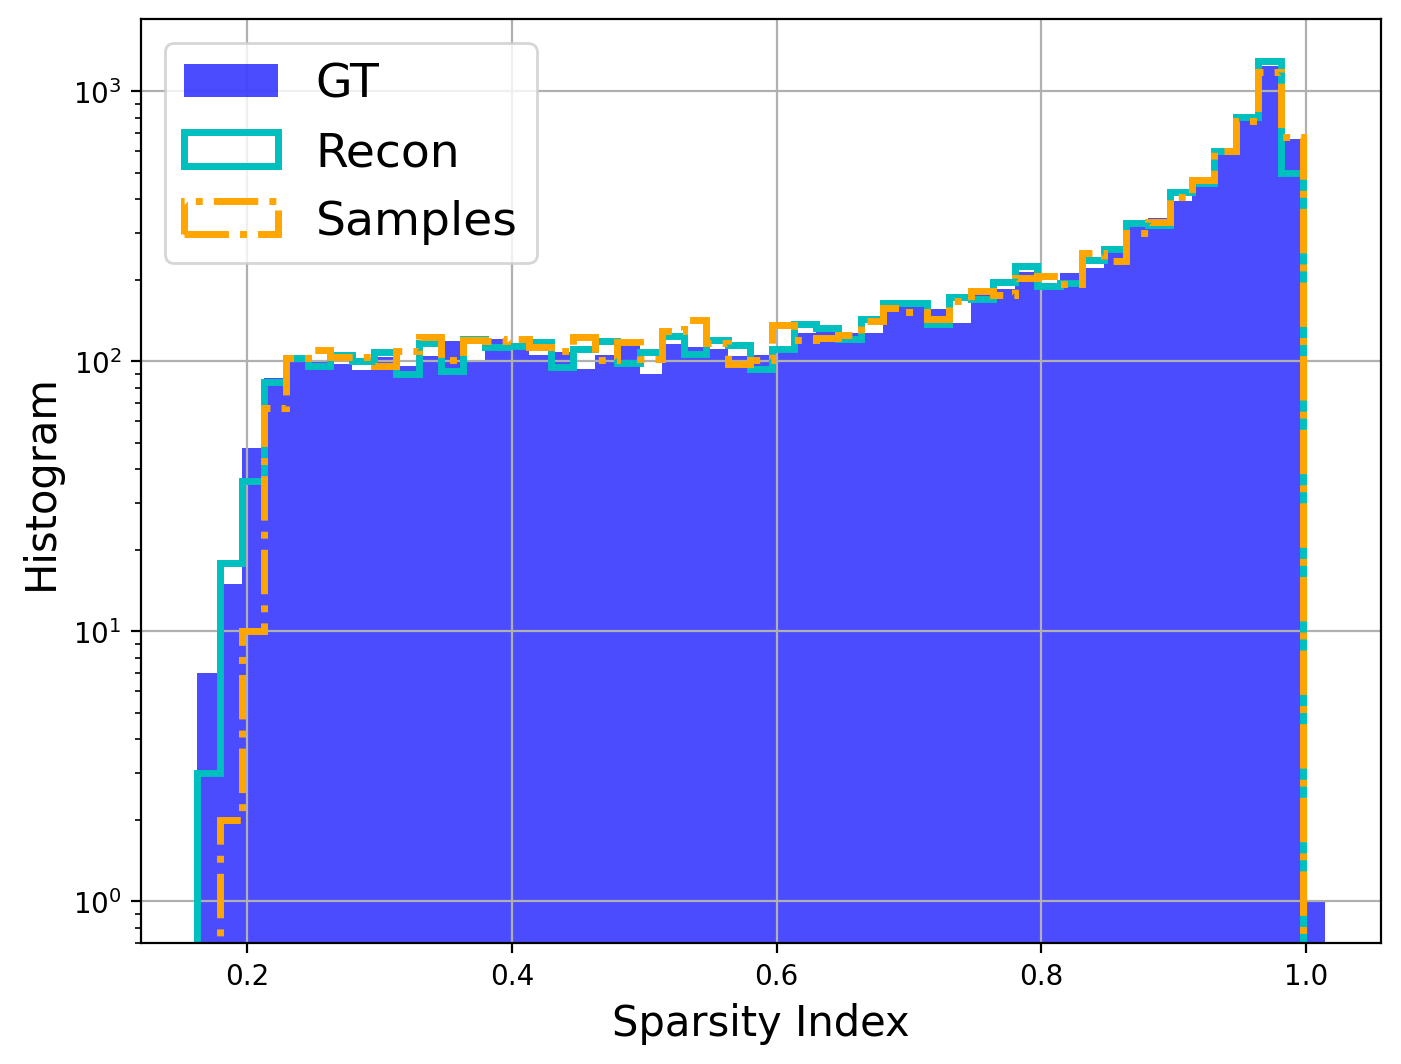

In [15]:
minVal, maxVal = min(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy()), max(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy())
binwidth = (maxVal-minVal)/50

plt.figure(figsize=(8,6))
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c")
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
# plt.hist(((xgen_samples_qpu == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=50, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
plt.xlabel("Sparsity Index", fontsize=15)
plt.ylabel("Histogram", fontsize=15)
plt.legend(["GT", "Recon", "Samples", "Sample /w QPU"], fontsize=17)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

<Figure size 800x600 with 0 Axes>

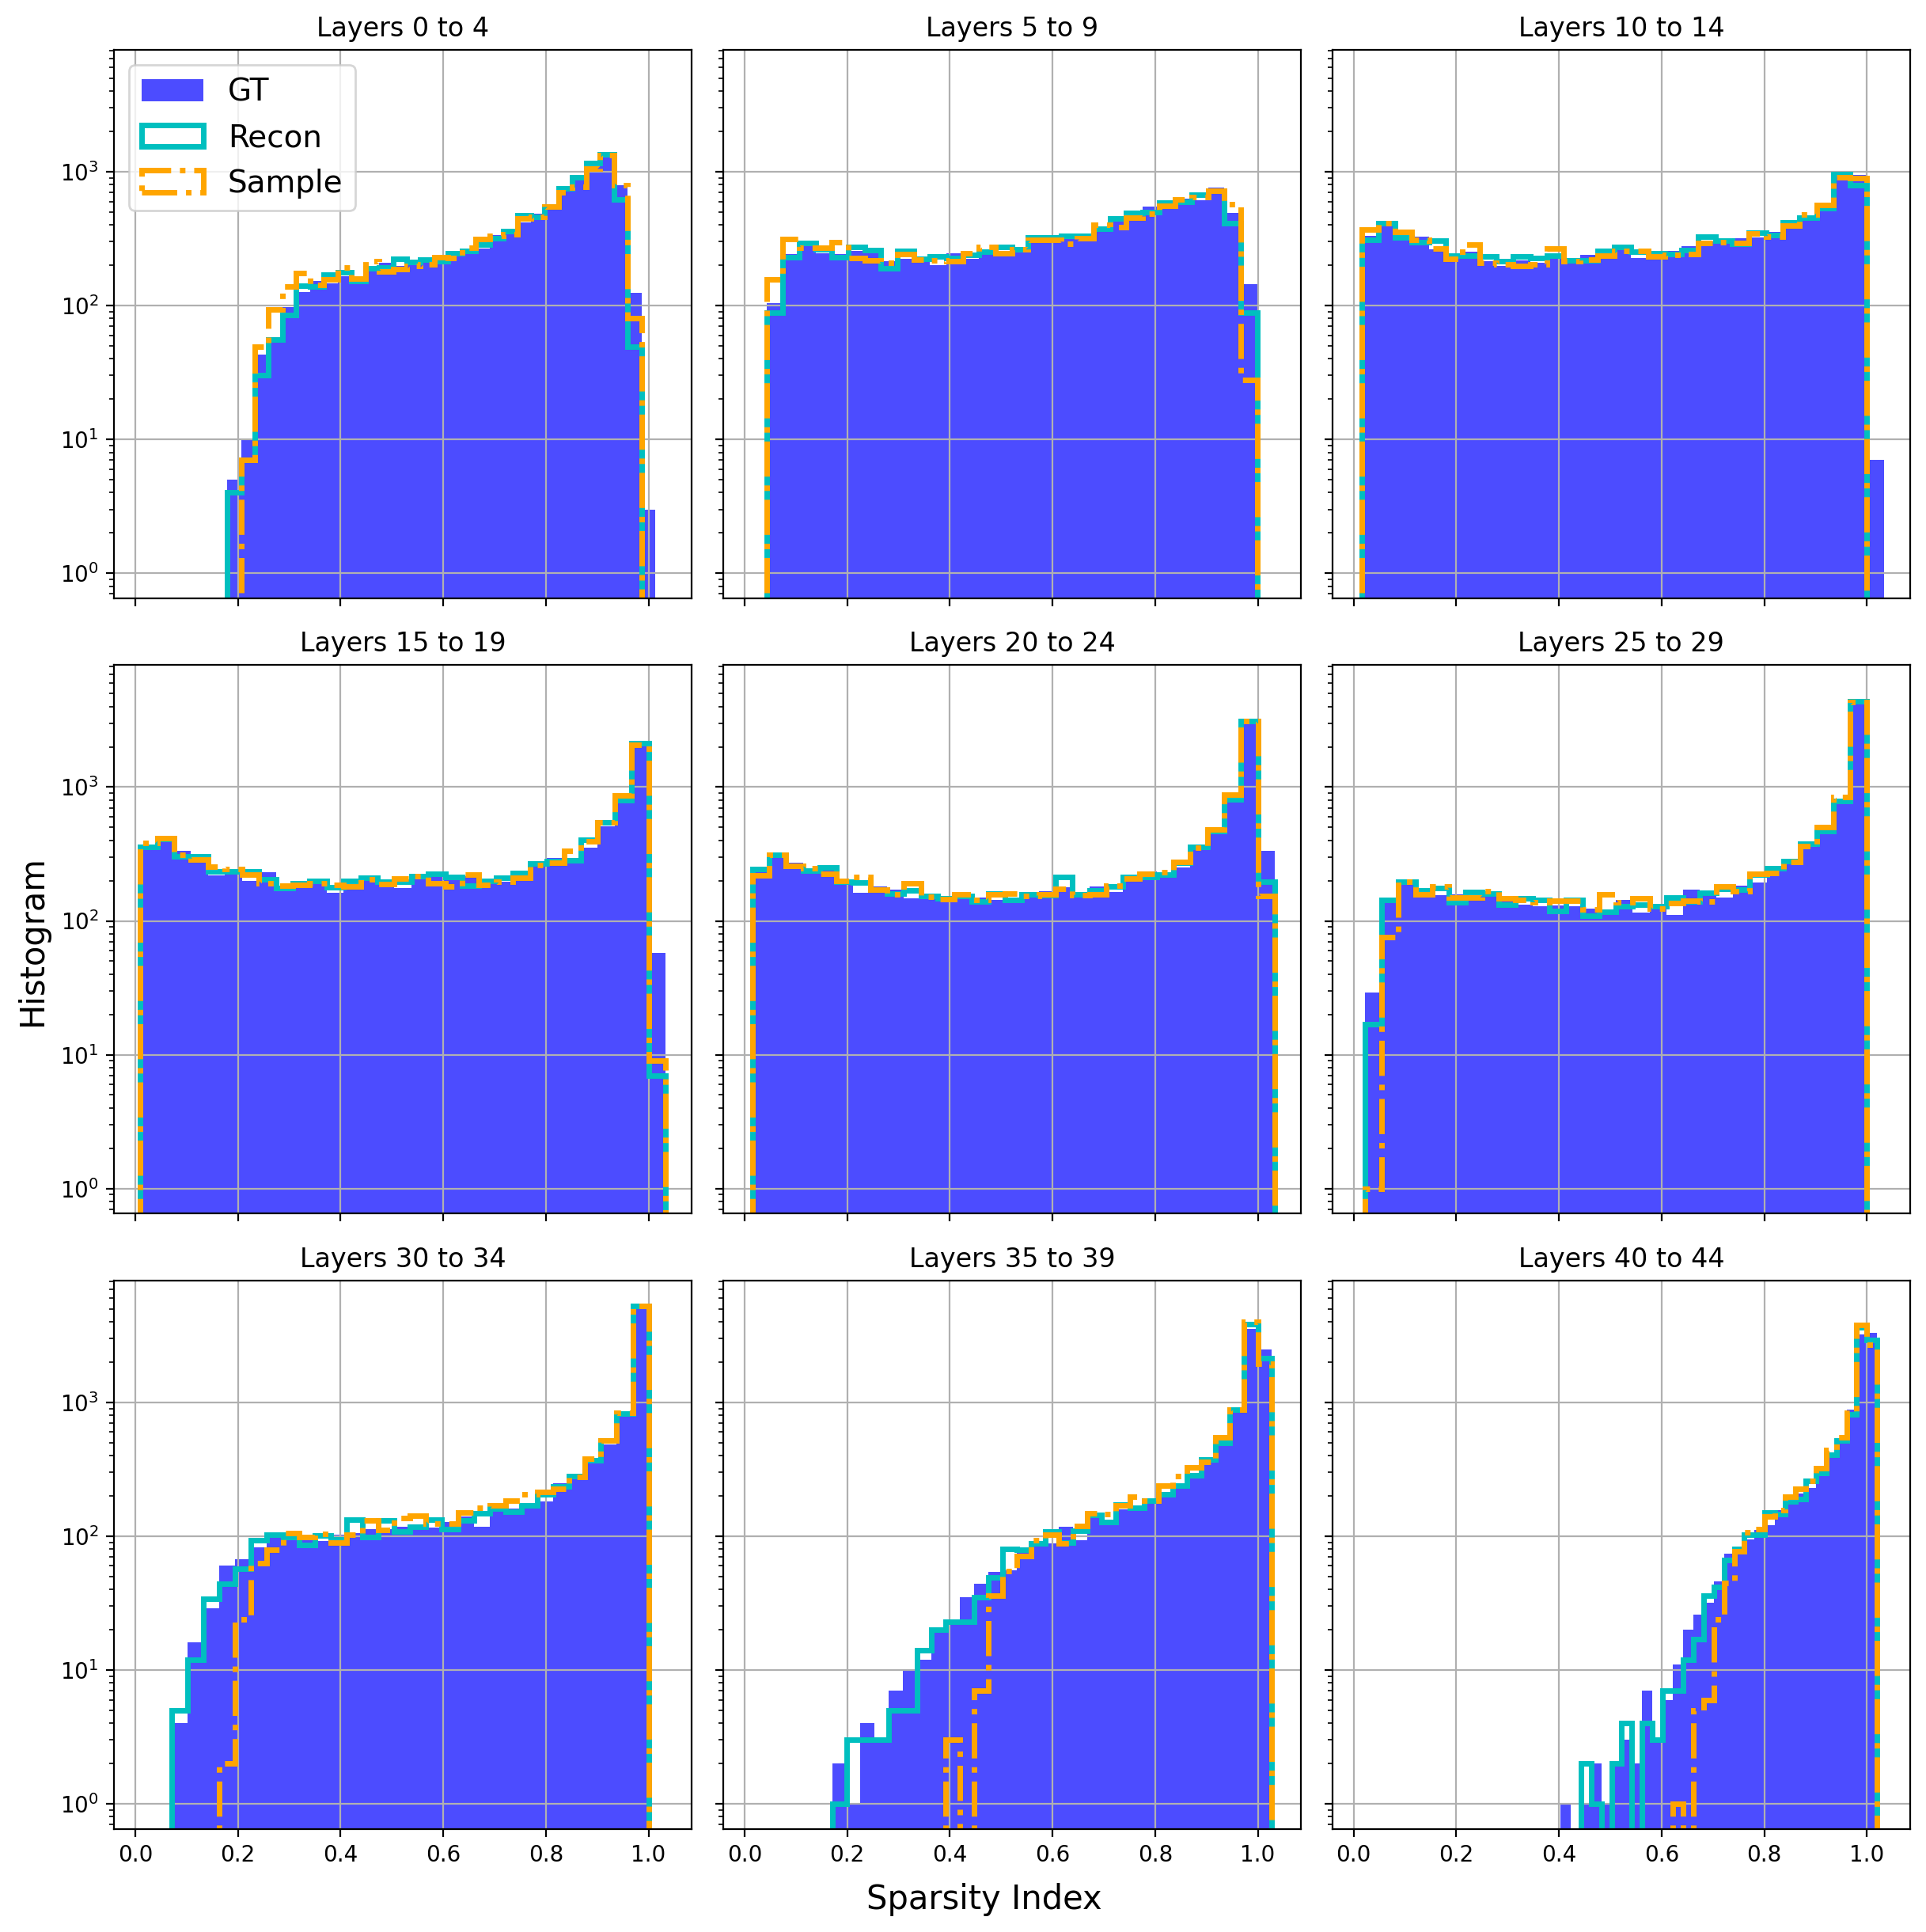

In [16]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, -0.01, 'Sparsity Index', ha='center', fontsize=15)
fig.text(-0.01, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    minVal, maxVal = min(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy()), max(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy())
    binwidth = (maxVal-minVal)/30
    ax.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(),  bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
    ax.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c")
    ax.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
    # ax.hist(((xgen_samples_qpu[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
    if i == 0:
        ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=14)
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}', fontsize=12)

# Adjust layout and display the plots
plt.tight_layout()
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


In [17]:
# plt.scatter(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), ((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(),  marker='.', alpha=.5, color="b")
# plt.scatter(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), ((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(),  marker='.', alpha=.5, color="orange")
# plt.plot([0,1],[0,1], c='red', lw=2.5)
# plt.xlabel('GT Sparsity Index', fontsize=15)
# plt.ylabel('Reconstruction Sparsity Index', fontsize=15)
# plt.grid("True")
# # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
# plt.show()

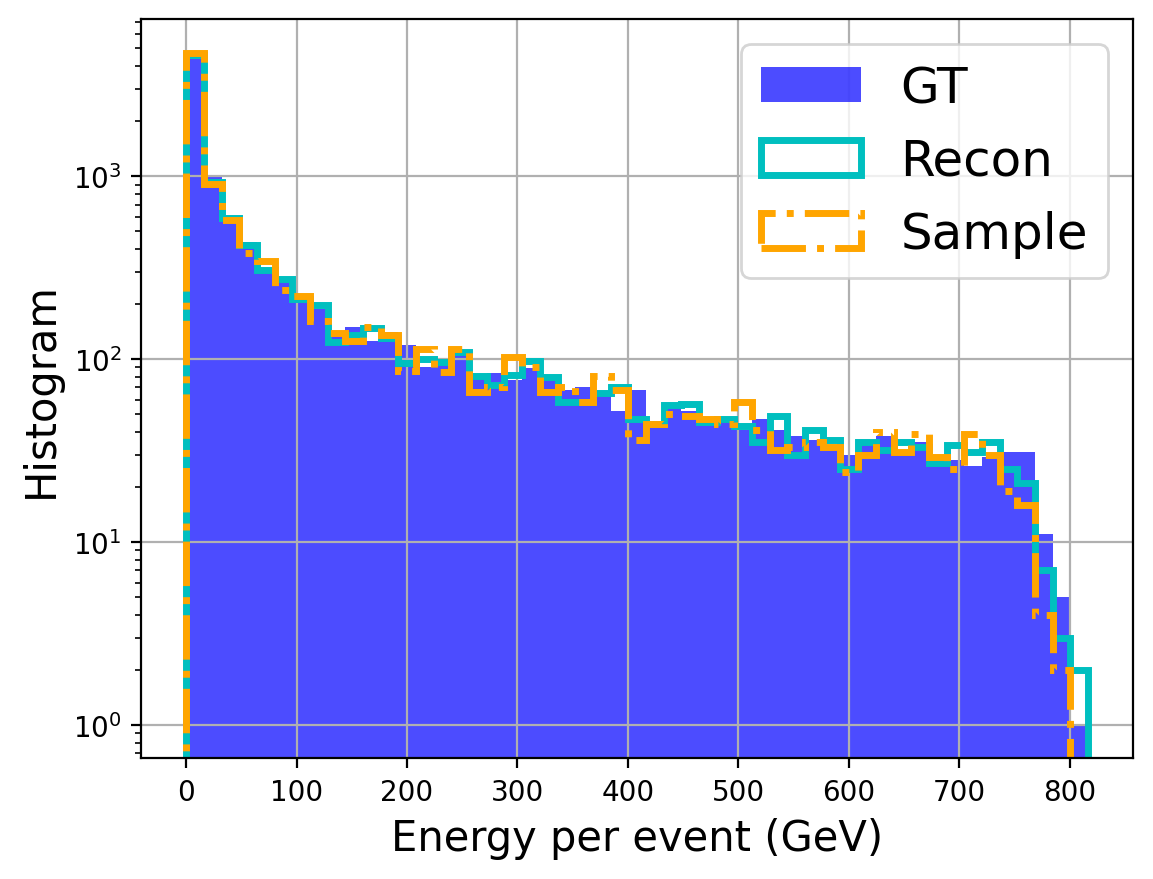

torch.Size([10000, 6480])


In [18]:
minVal, maxVal = min(xtarget_samples.sum(dim=1).numpy()/1000), max(xtarget_samples.sum(dim=1).numpy()/1000)
binwidth = (maxVal-minVal)/50
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', alpha=1.0, linewidth=2.5, color="c")
plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', alpha=1.0, linewidth=2.5, color="orange", linestyle="dashdot")
# plt.hist(xgen_samples_qpu.sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="m", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="b")
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
plt.xlabel("Energy per event (GeV)", fontsize=15)

plt.ylabel("Histogram", fontsize=15)
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=18)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(xgen_samples.shape)

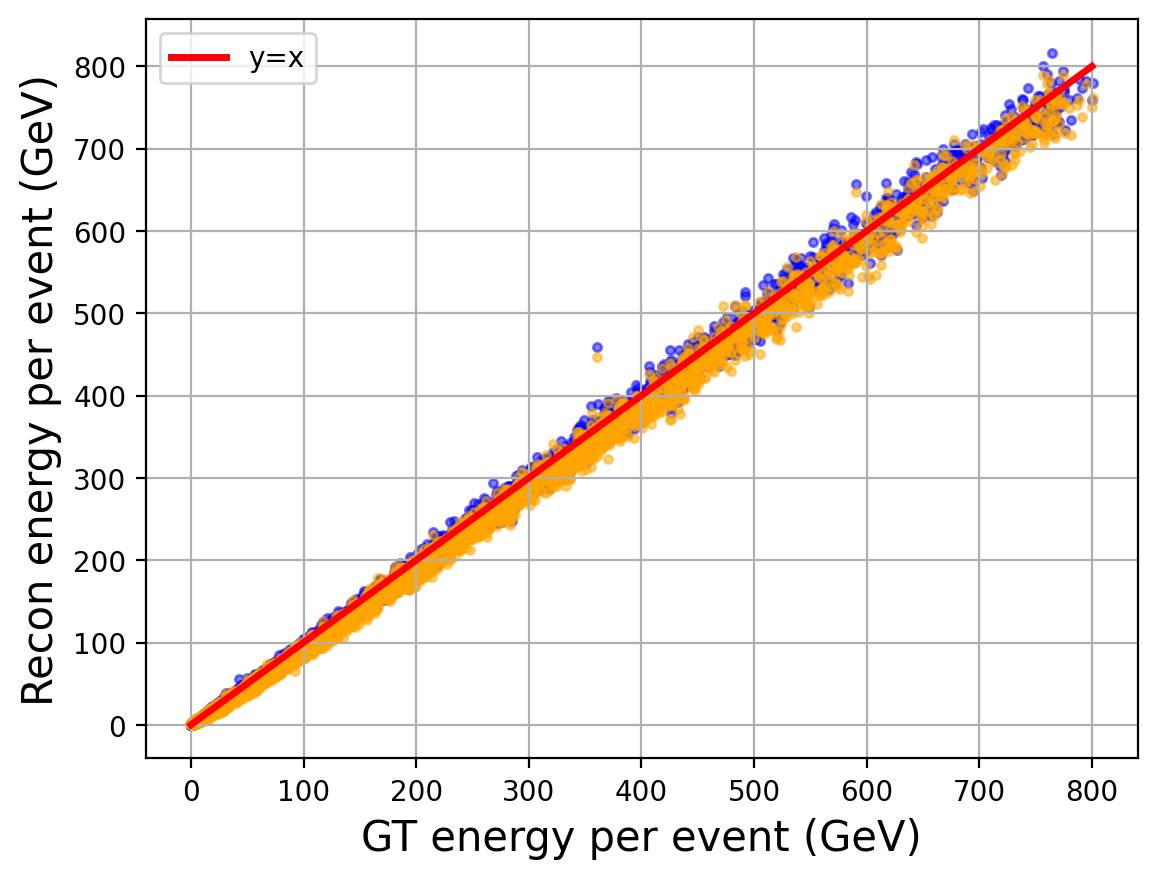

In [19]:
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xgen_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="orange")
plt.plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
plt.legend()
plt.grid("True")
plt.xlabel("GT energy per event (GeV)", fontsize=15)
plt.ylabel("Recon energy per event (GeV)", fontsize=15)
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [20]:
# fig, axes = plt.subplots(3,2, figsize=(8,8), tight_layout=True)
# fig.text(0.5, 0.0, 'GT energy per event (GeV)', ha='center')
# # fig.text(0.5, 1.0, f'{ds[part]}', ha='center', fontsize=12)

# axes[0,0].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
# axes[0,0].plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# # axes[0,0].plot([0,3800],[0,3800], c='red', lw=2.5, label='y=x')
# axes[0,0].set_ylabel("Recon energy per event (GeV)")
# axes[0,0].legend()
# axes[0,0].grid("True")
# axes[0,0].set_yscale('log')
# axes[0,0].set_xscale('log')

# axes[0,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, (xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/1000, marker='.', alpha=0.6, color="b")
# axes[0,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, (xtarget_samples.sum(dim=1).numpy() - xgen_samples.sum(dim=1).numpy())/1000, marker='.', alpha=0.2, color="orange")
# # axes[0,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, (xtarget_samples.sum(dim=1).numpy() - xgen_samples_qpu.sum(dim=1).numpy())/1000, marker='.', alpha=0.1, color="m")
# # plt.plot([0,20],[0,20], c='red', lw=2)
# # axes[0,1].set_xlabel("GT energy per event (GeV)")
# axes[0,1].set_ylabel("Abs error (GeV)")
# axes[0,1].set_ylim([-40,40])
# # axes[0,1].legend()
# # axes[0,1].set_yscale('log')
# axes[0,1].grid("True")

# # axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
# # axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
# axes[1,0].scatter(1/(entarget_samples.numpy()/1000), np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
# axes[1,0].scatter(1/(entarget_samples.numpy()/1000), np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
# axes[1,0].plot([1e-3,1e0],np.power([1e-3,1e0],0.25)*np.power(10,2.0), c='orange', lw=2.5, label='slope=0.25', linestyle="dashdot")
# axes[1,0].grid("True")
# axes[1,0].set_yscale('log')
# axes[1,0].set_xscale('log')
# axes[1,0].legend()
# axes[1,0].set_ylabel("Relative Error")

# # axes[1,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, np.abs(xtarget_samples.sum(dim=1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.5, color="blue")
# axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xtarget_samples.sum(dim=1).numpy()/1000), marker='.', alpha=1, color="blue", label="Simulation")
# axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.2, color="red", label="Model")
# axes[1,1].plot([1,800],np.sqrt([1,800]), c='orange', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
# axes[1,1].plot([1,800],[1,800], c='c', lw=2.5, label='y=x', linestyle="dashed")
# # axes[1,1].set_title(f'{ds[part]}')
# axes[1,1].grid("True")
# axes[1,1].set_yscale('log')
# axes[1,1].set_xscale('log')
# axes[1,1].set_ylabel("Absolute Error")
# axes[1,1].legend()


# # Merge the first row's axes
# gs = axes[2, 0].get_gridspec()
# for ax in axes[2, :]:
#     ax.remove()
# ax_big = fig.add_subplot(gs[2, :])
# ax_big.scatter(1/(xtarget_samples.sum(dim=1).numpy()/1000), np.abs(xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/(xtarget_samples.sum(dim=1).numpy()+1e-3), marker='.', alpha=.5, color="blue")
# ax_big.scatter(1/(xtarget_samples.sum(dim=1).numpy()/1000), np.abs(xtarget_samples.sum(dim=1).numpy() - xtarget_samples.sum(dim=1).numpy())/(xtarget_samples.sum(dim=1).numpy()+1e-3), marker='.', alpha=.5, color="orange")
# # axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
# # axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
# # axes[1,0].set_title(f'{ds[part]}')
# ax_big.plot([1e-3,1e1],np.sqrt([1e-3,1e1])*np.power(1,3.5), c='orange', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
# # axes[1,1].plot([1e-9,1e-6],np.linspace(1e-9,1e-6)*np.power(10,3.5), c='c', lw=2.5, label='y=x', linestyle="dashed")
# ax_big.grid("True")
# ax_big.set_yscale('log')
# ax_big.set_xscale('log')
# ax_big.legend()
# ax_big.set_ylim([1e-5,1e1])
# ax_big.set_yticks([1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1])
# ax_big.set_ylabel("Relative Recon Error")
# # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_scatter_4panels_{modelname}_{arch}_{datascaled}_{part}.png')
# plt.show()

<Figure size 800x600 with 0 Axes>

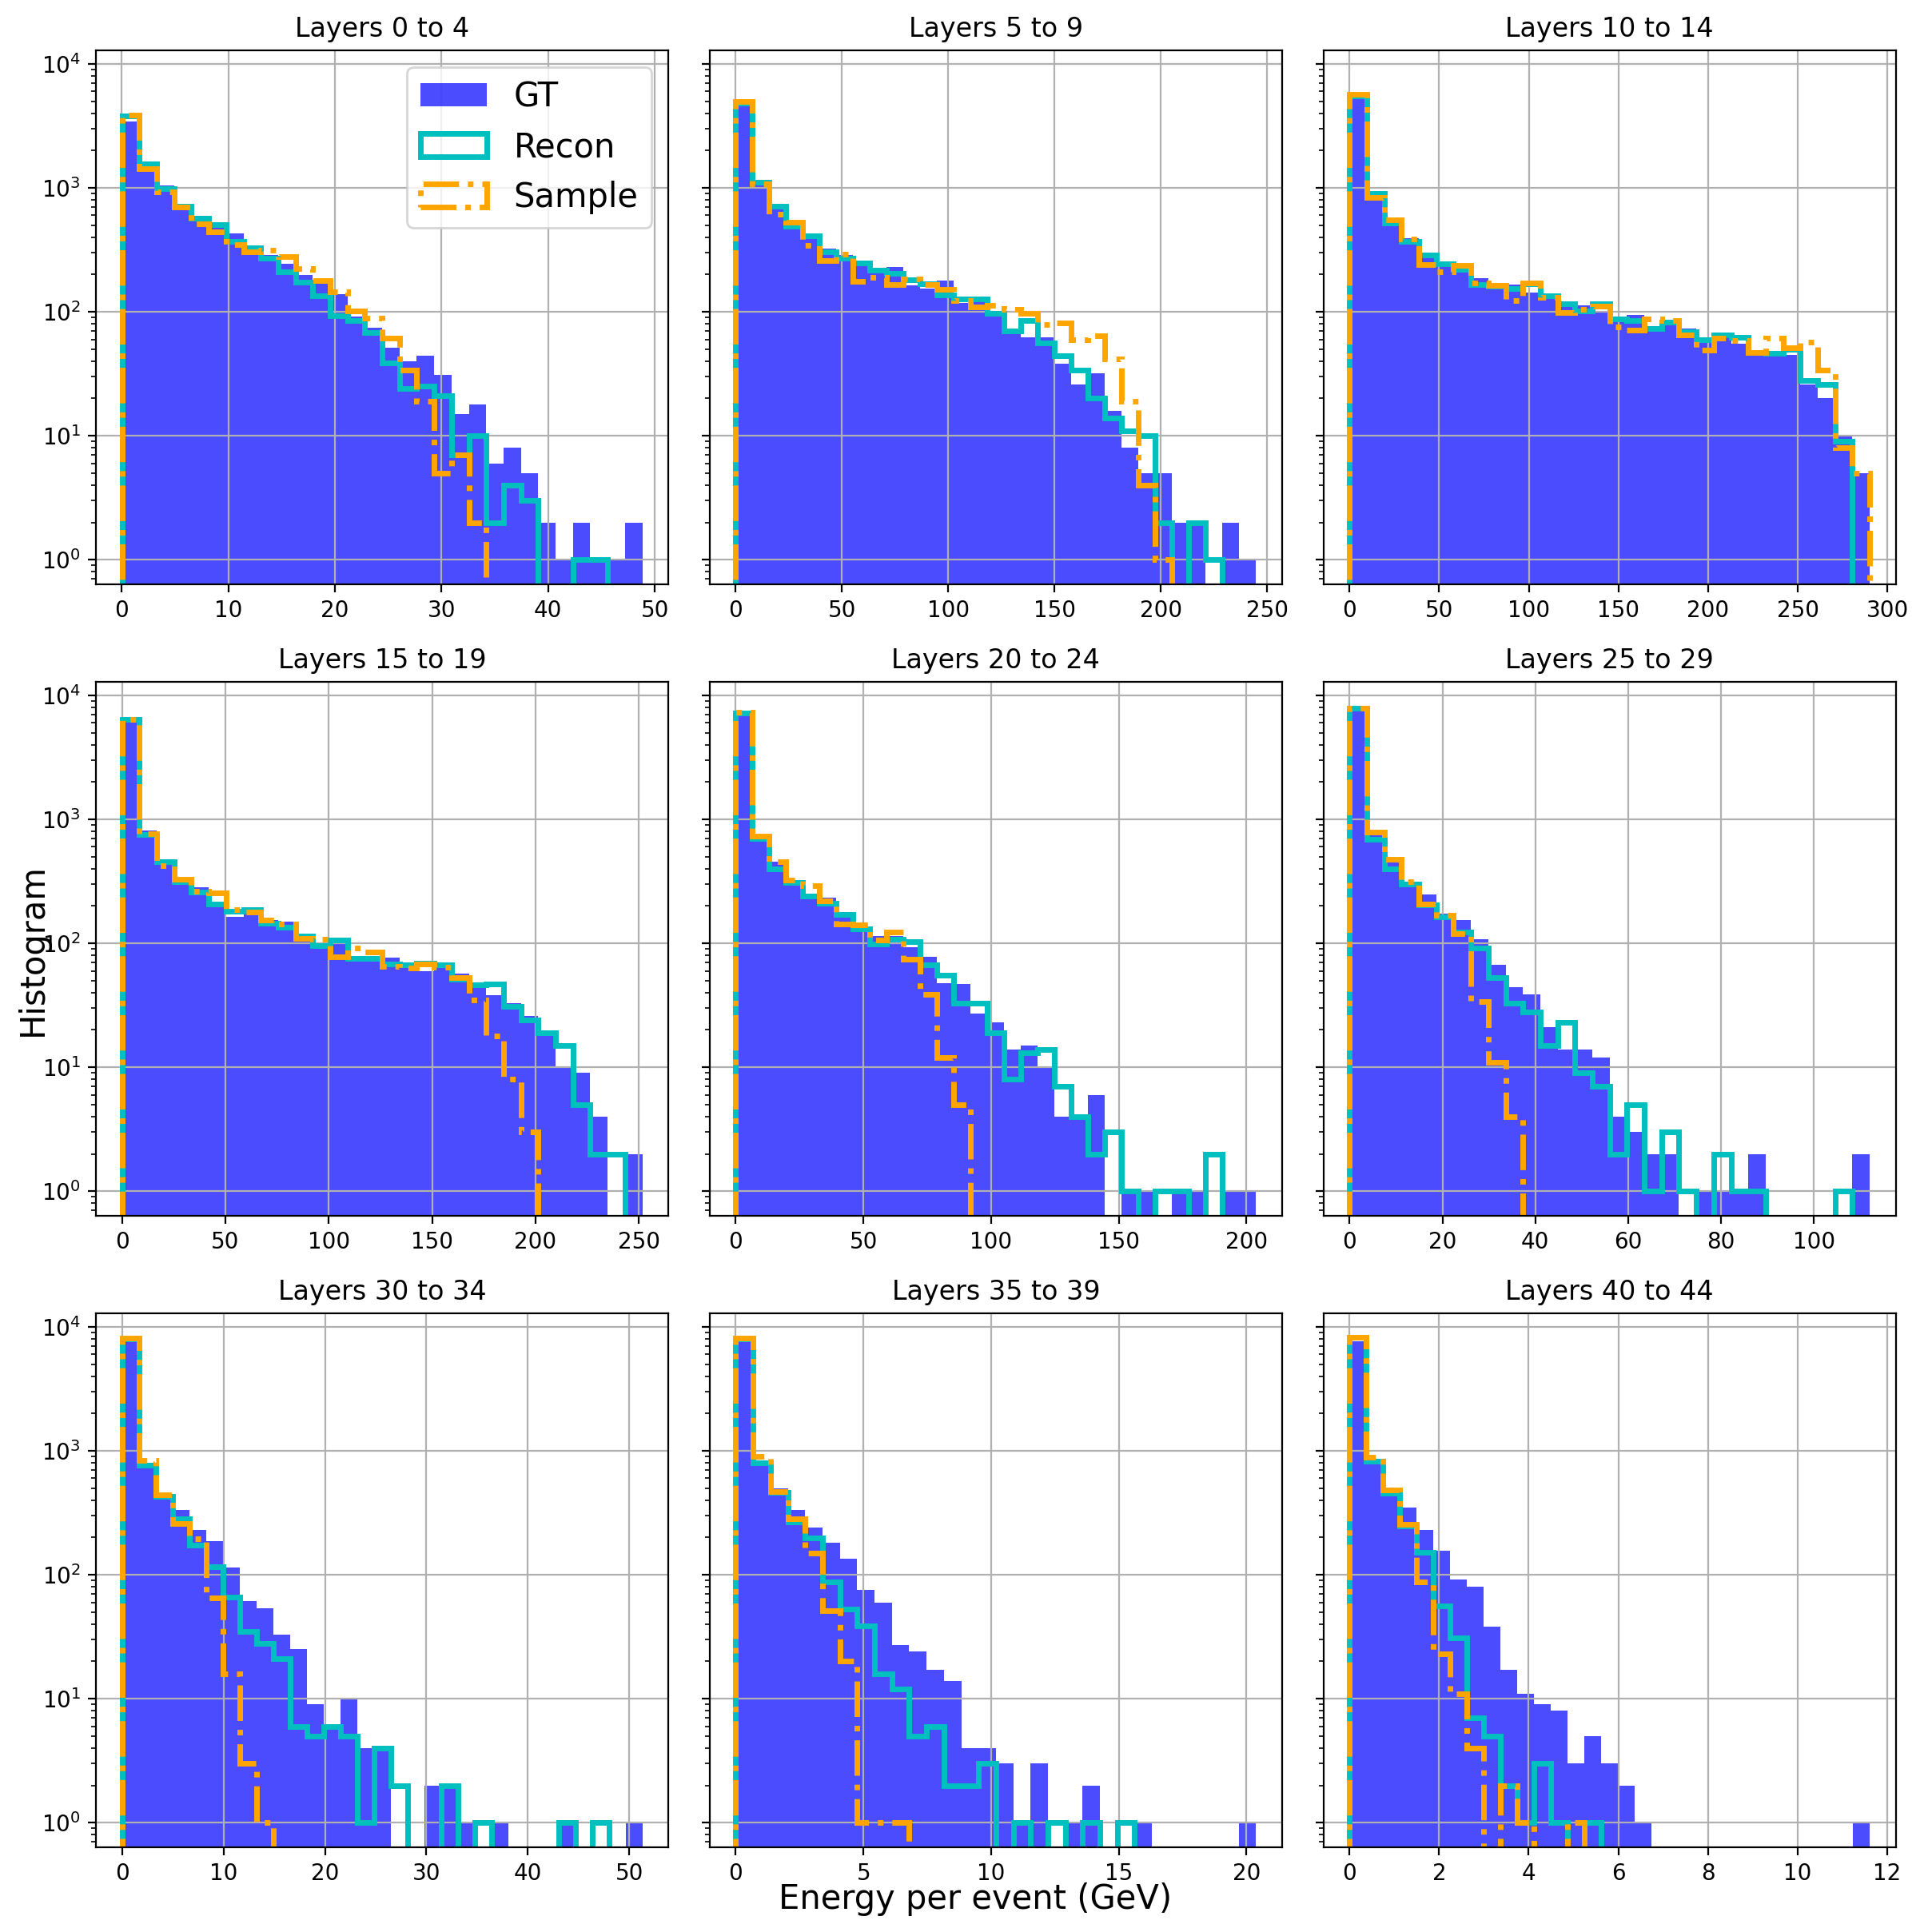

In [21]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center', fontsize=15)
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    minVal, maxVal = min(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000), max(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000)
    binwidth = (maxVal-minVal)/30
    ax.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
    ax.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c")
    # ax.hist(xrecon_samples_2[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
    # ax.hist(xgen_samples_qpu[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
    if i == 0:
        # ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
        ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=15)
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


In [22]:
# minVal, maxVal = min(xtarget_samples[:30,:].view(-1)), max(xtarget_samples[:30,:].view(-1))
# binwidth = (maxVal-minVal)/30

# plt.hist(xtarget_samples[:30,:].view(-1), bins=50, density=True, log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
# plt.hist(xrecon_samples[:30,:].view(-1), bins=40, density=True, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="c")
# plt.hist(xgen_samples[:30,:].view(-1), bins=40, density=True, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="orange", linestyle="dashdot")
# plt.xlabel("Energy per voxel (MeV)", fontsize=15)

# plt.ylabel("Histogram", fontsize=15)
# plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=18)
# plt.grid("True")
# # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_per_voxel_{modelname}_{arch}_{datascaled}_{part}.png')
# plt.show()
# print(xtarget_samples.view(-1).shape)

In [23]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,44]

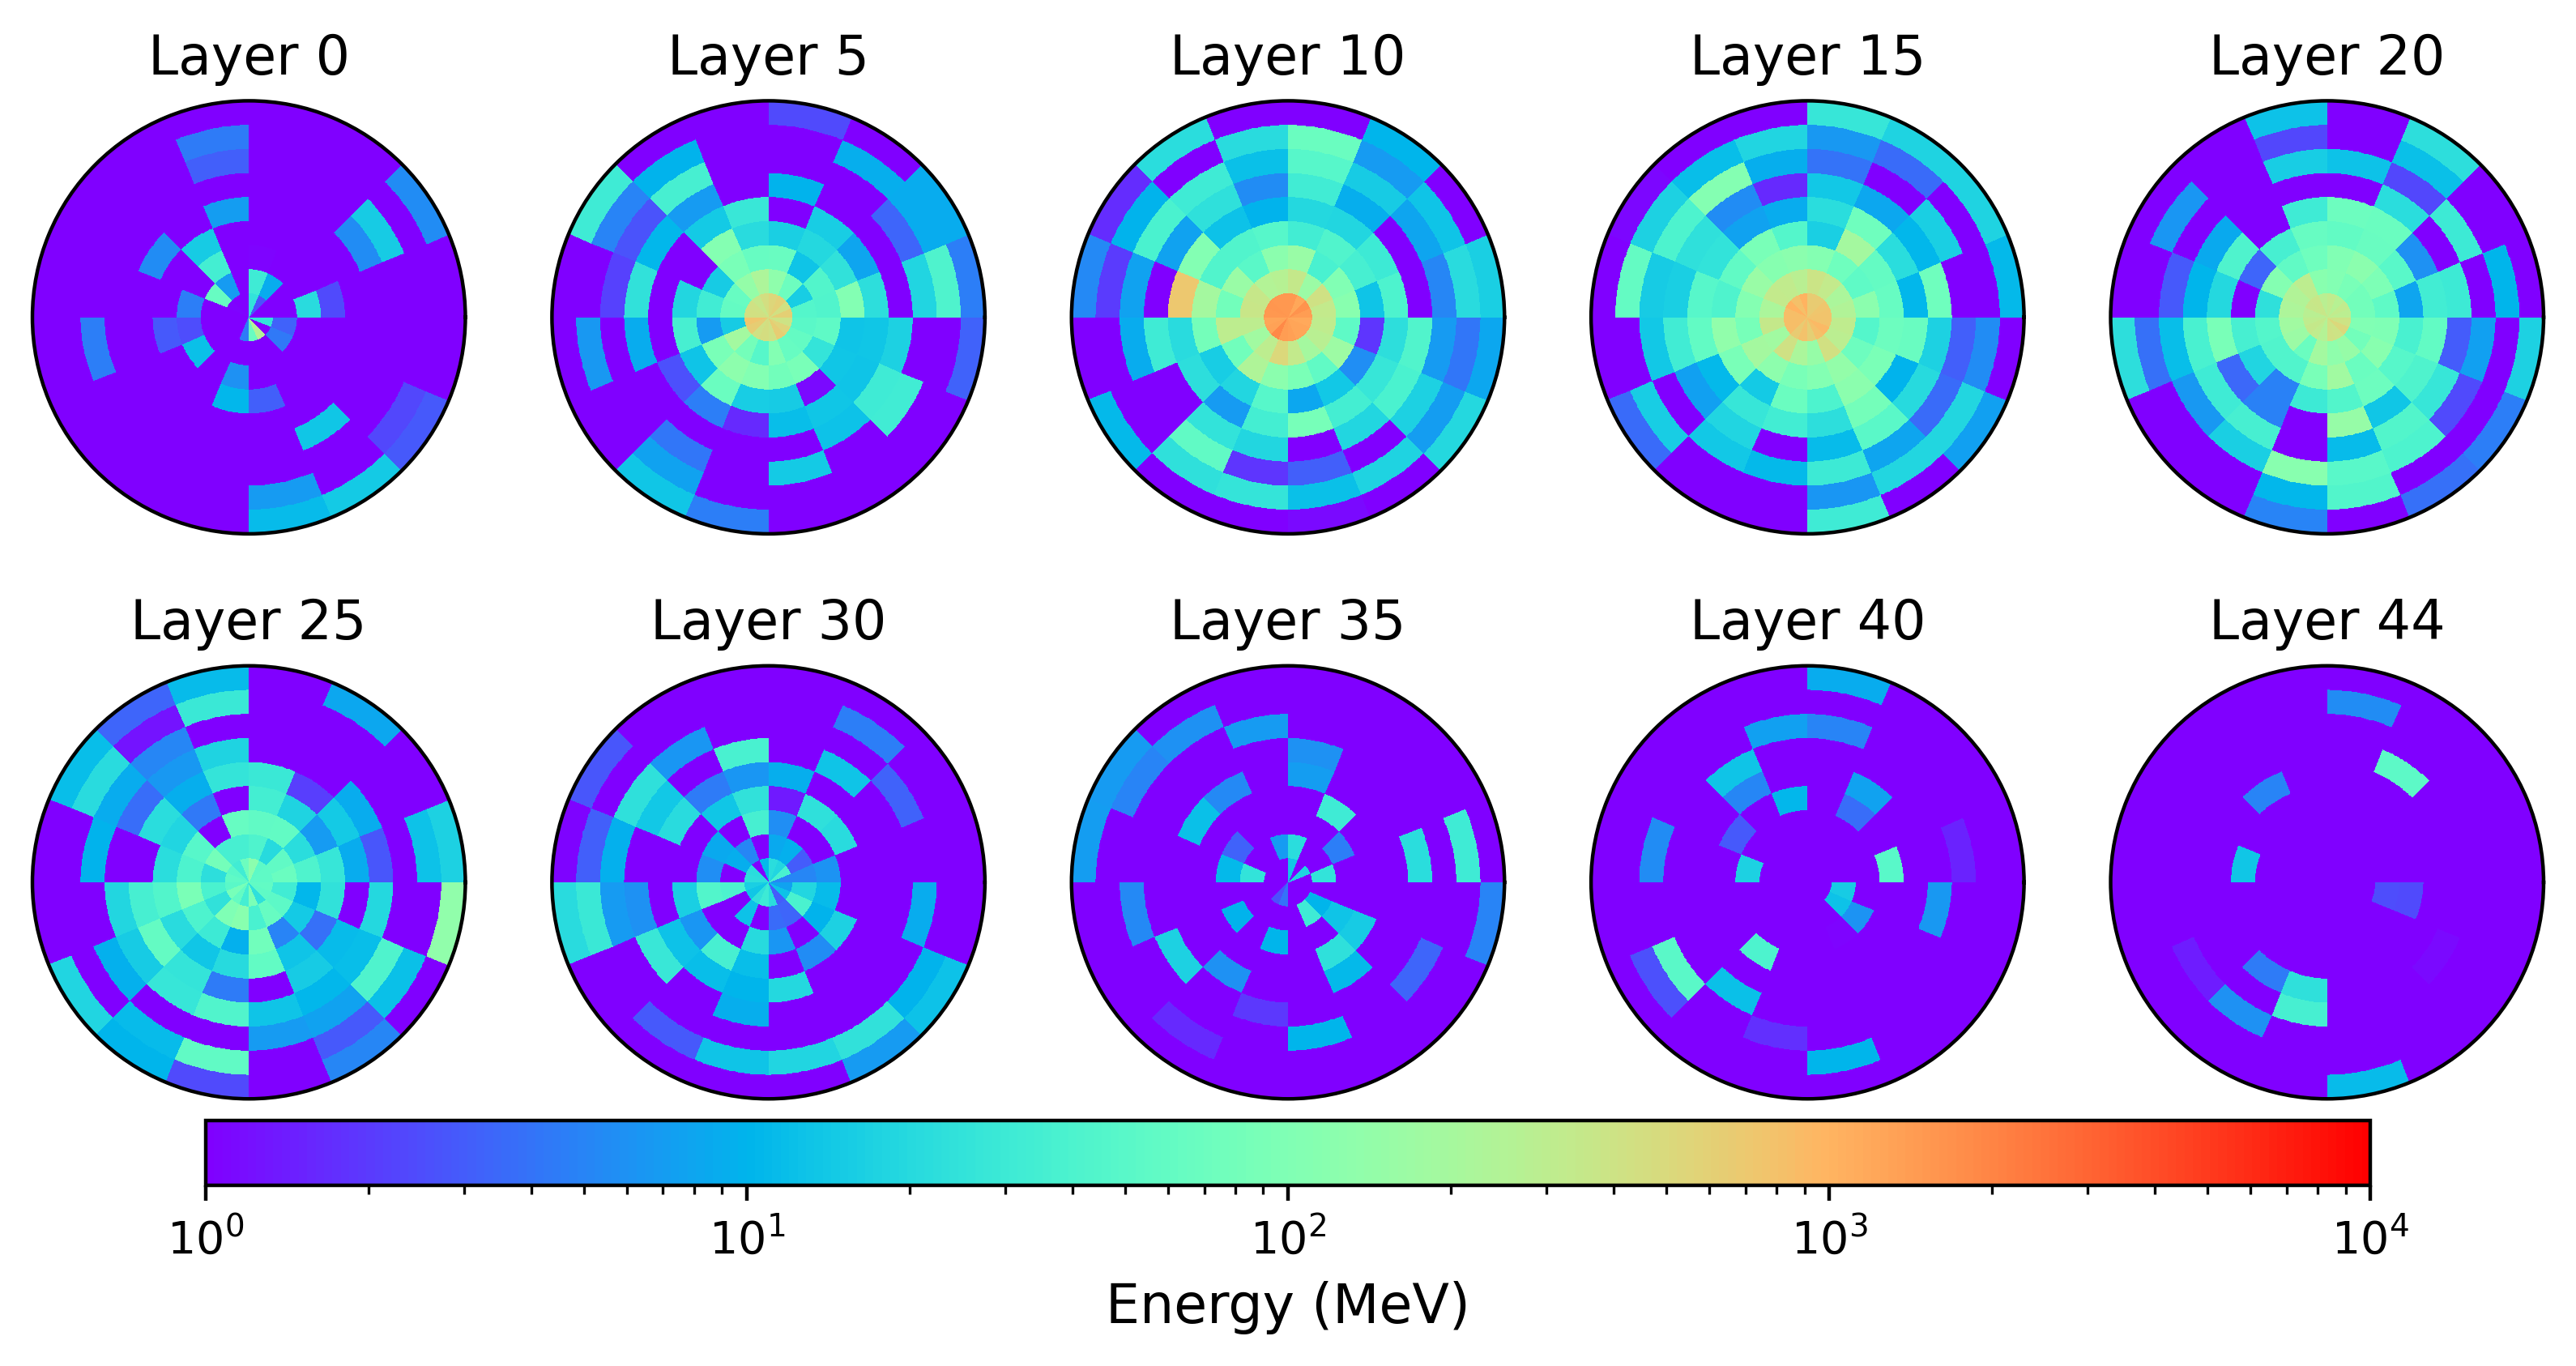

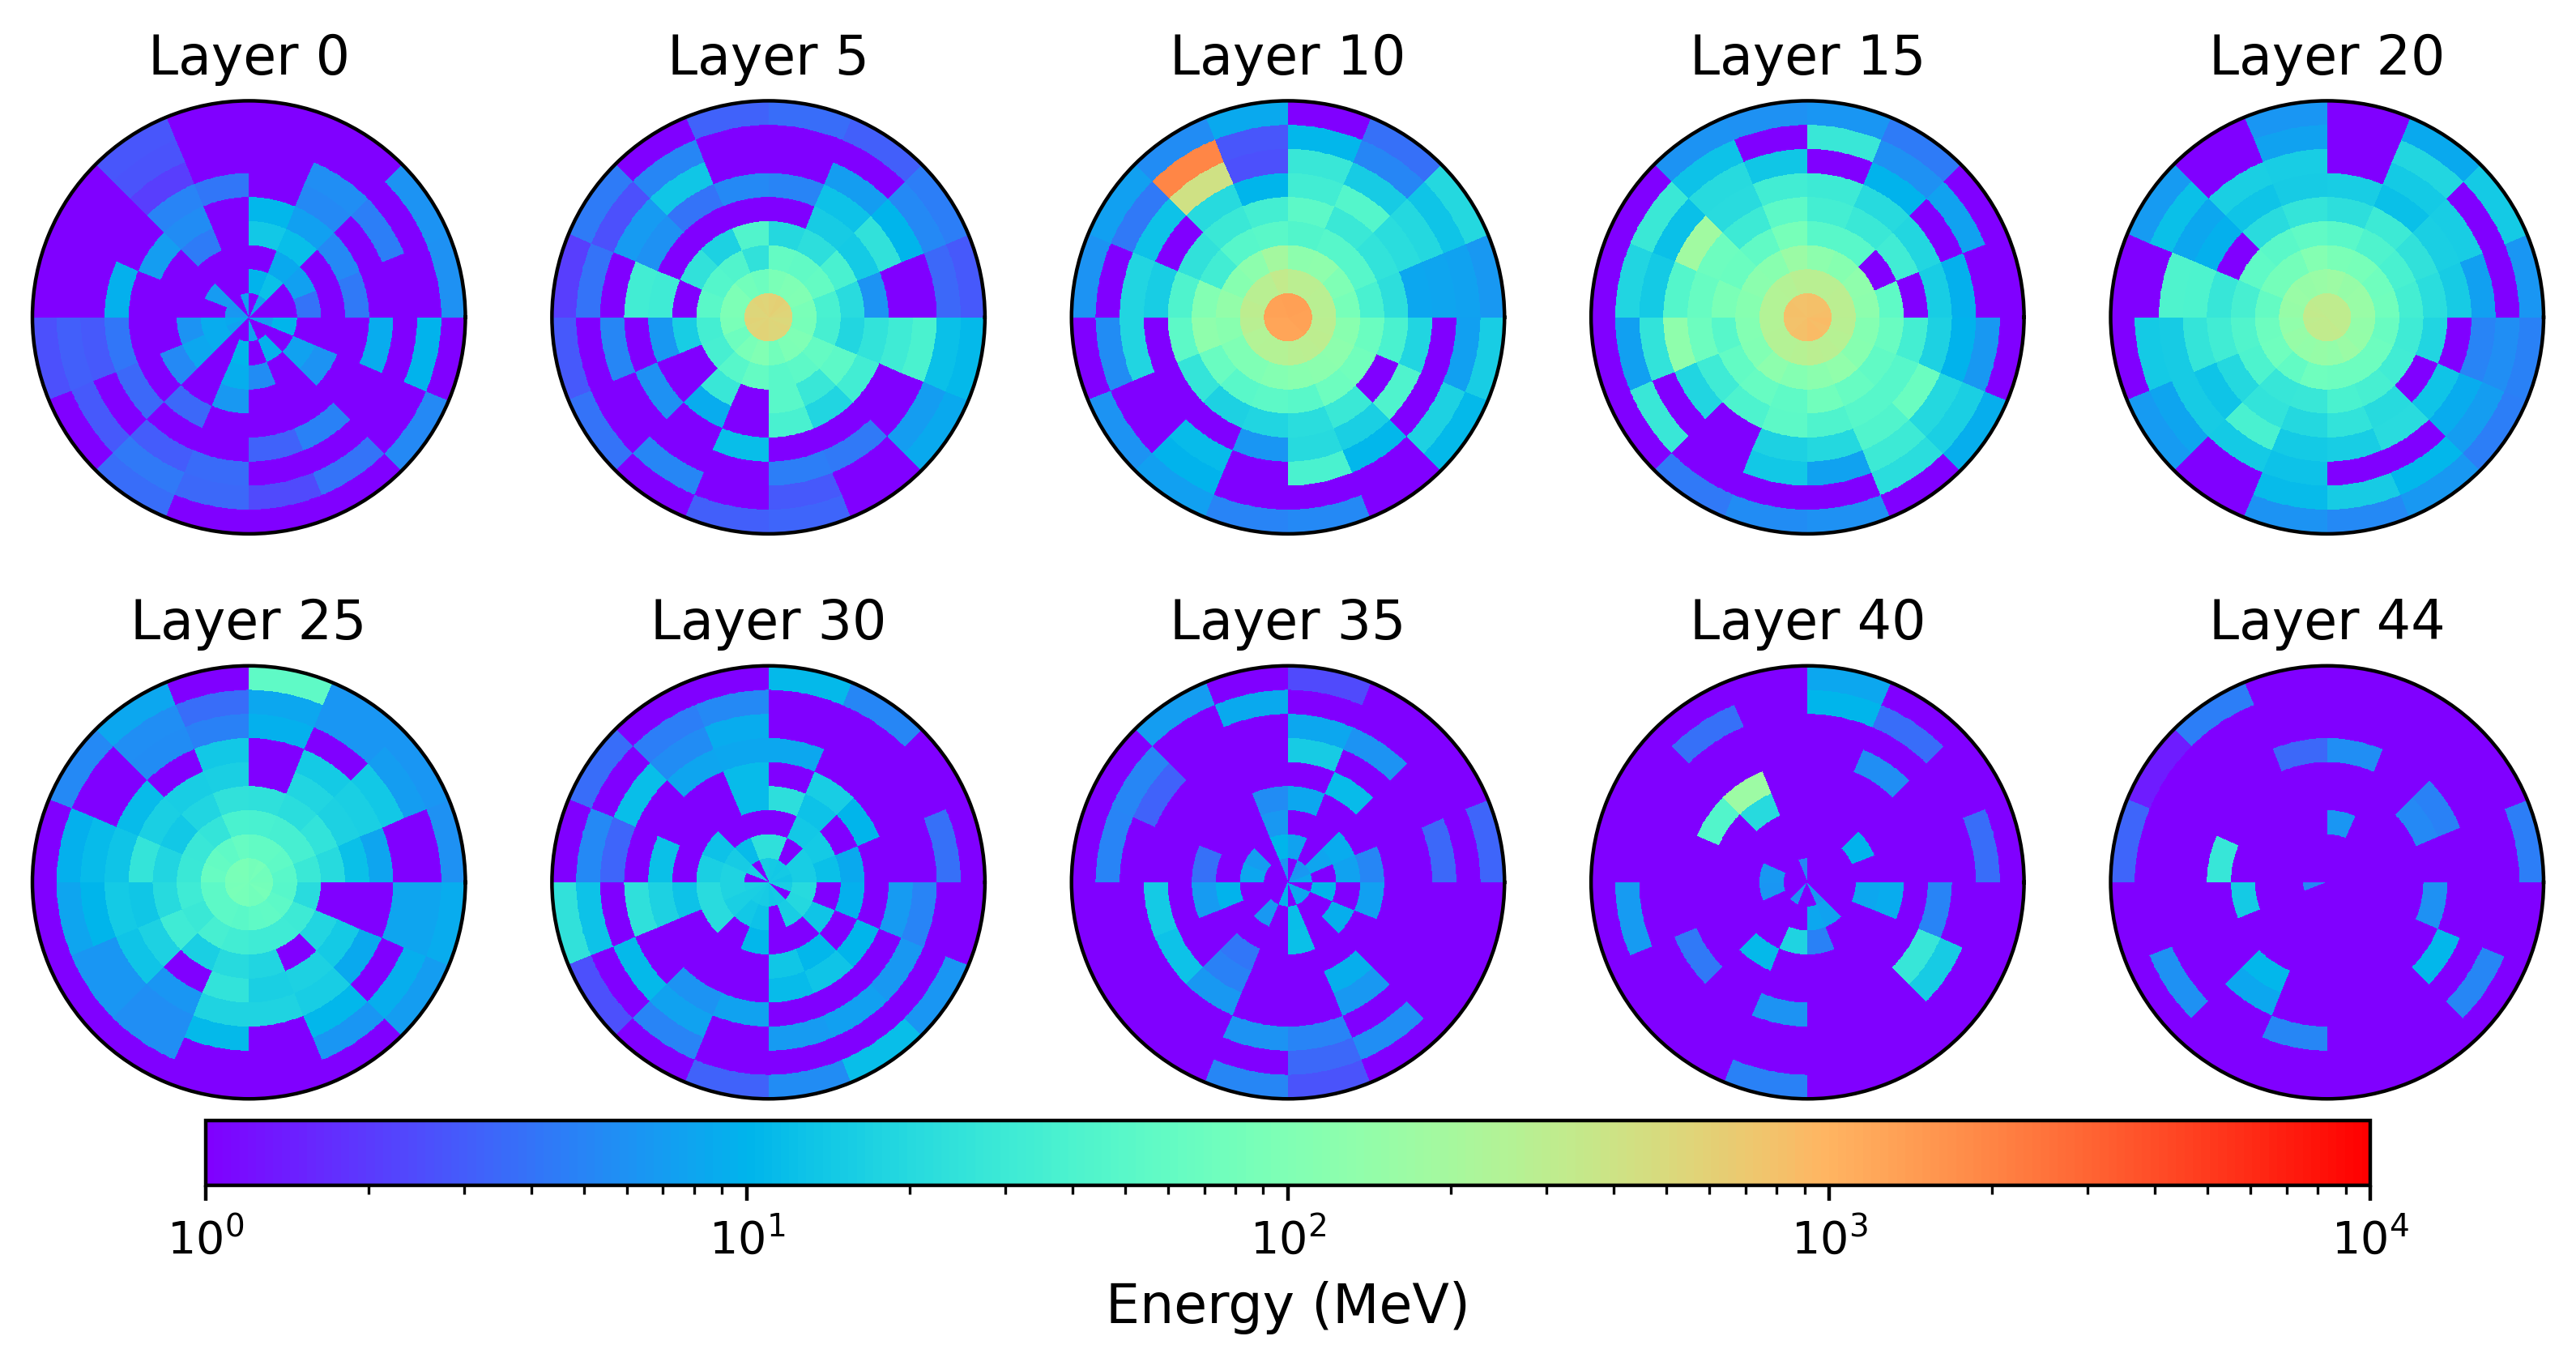

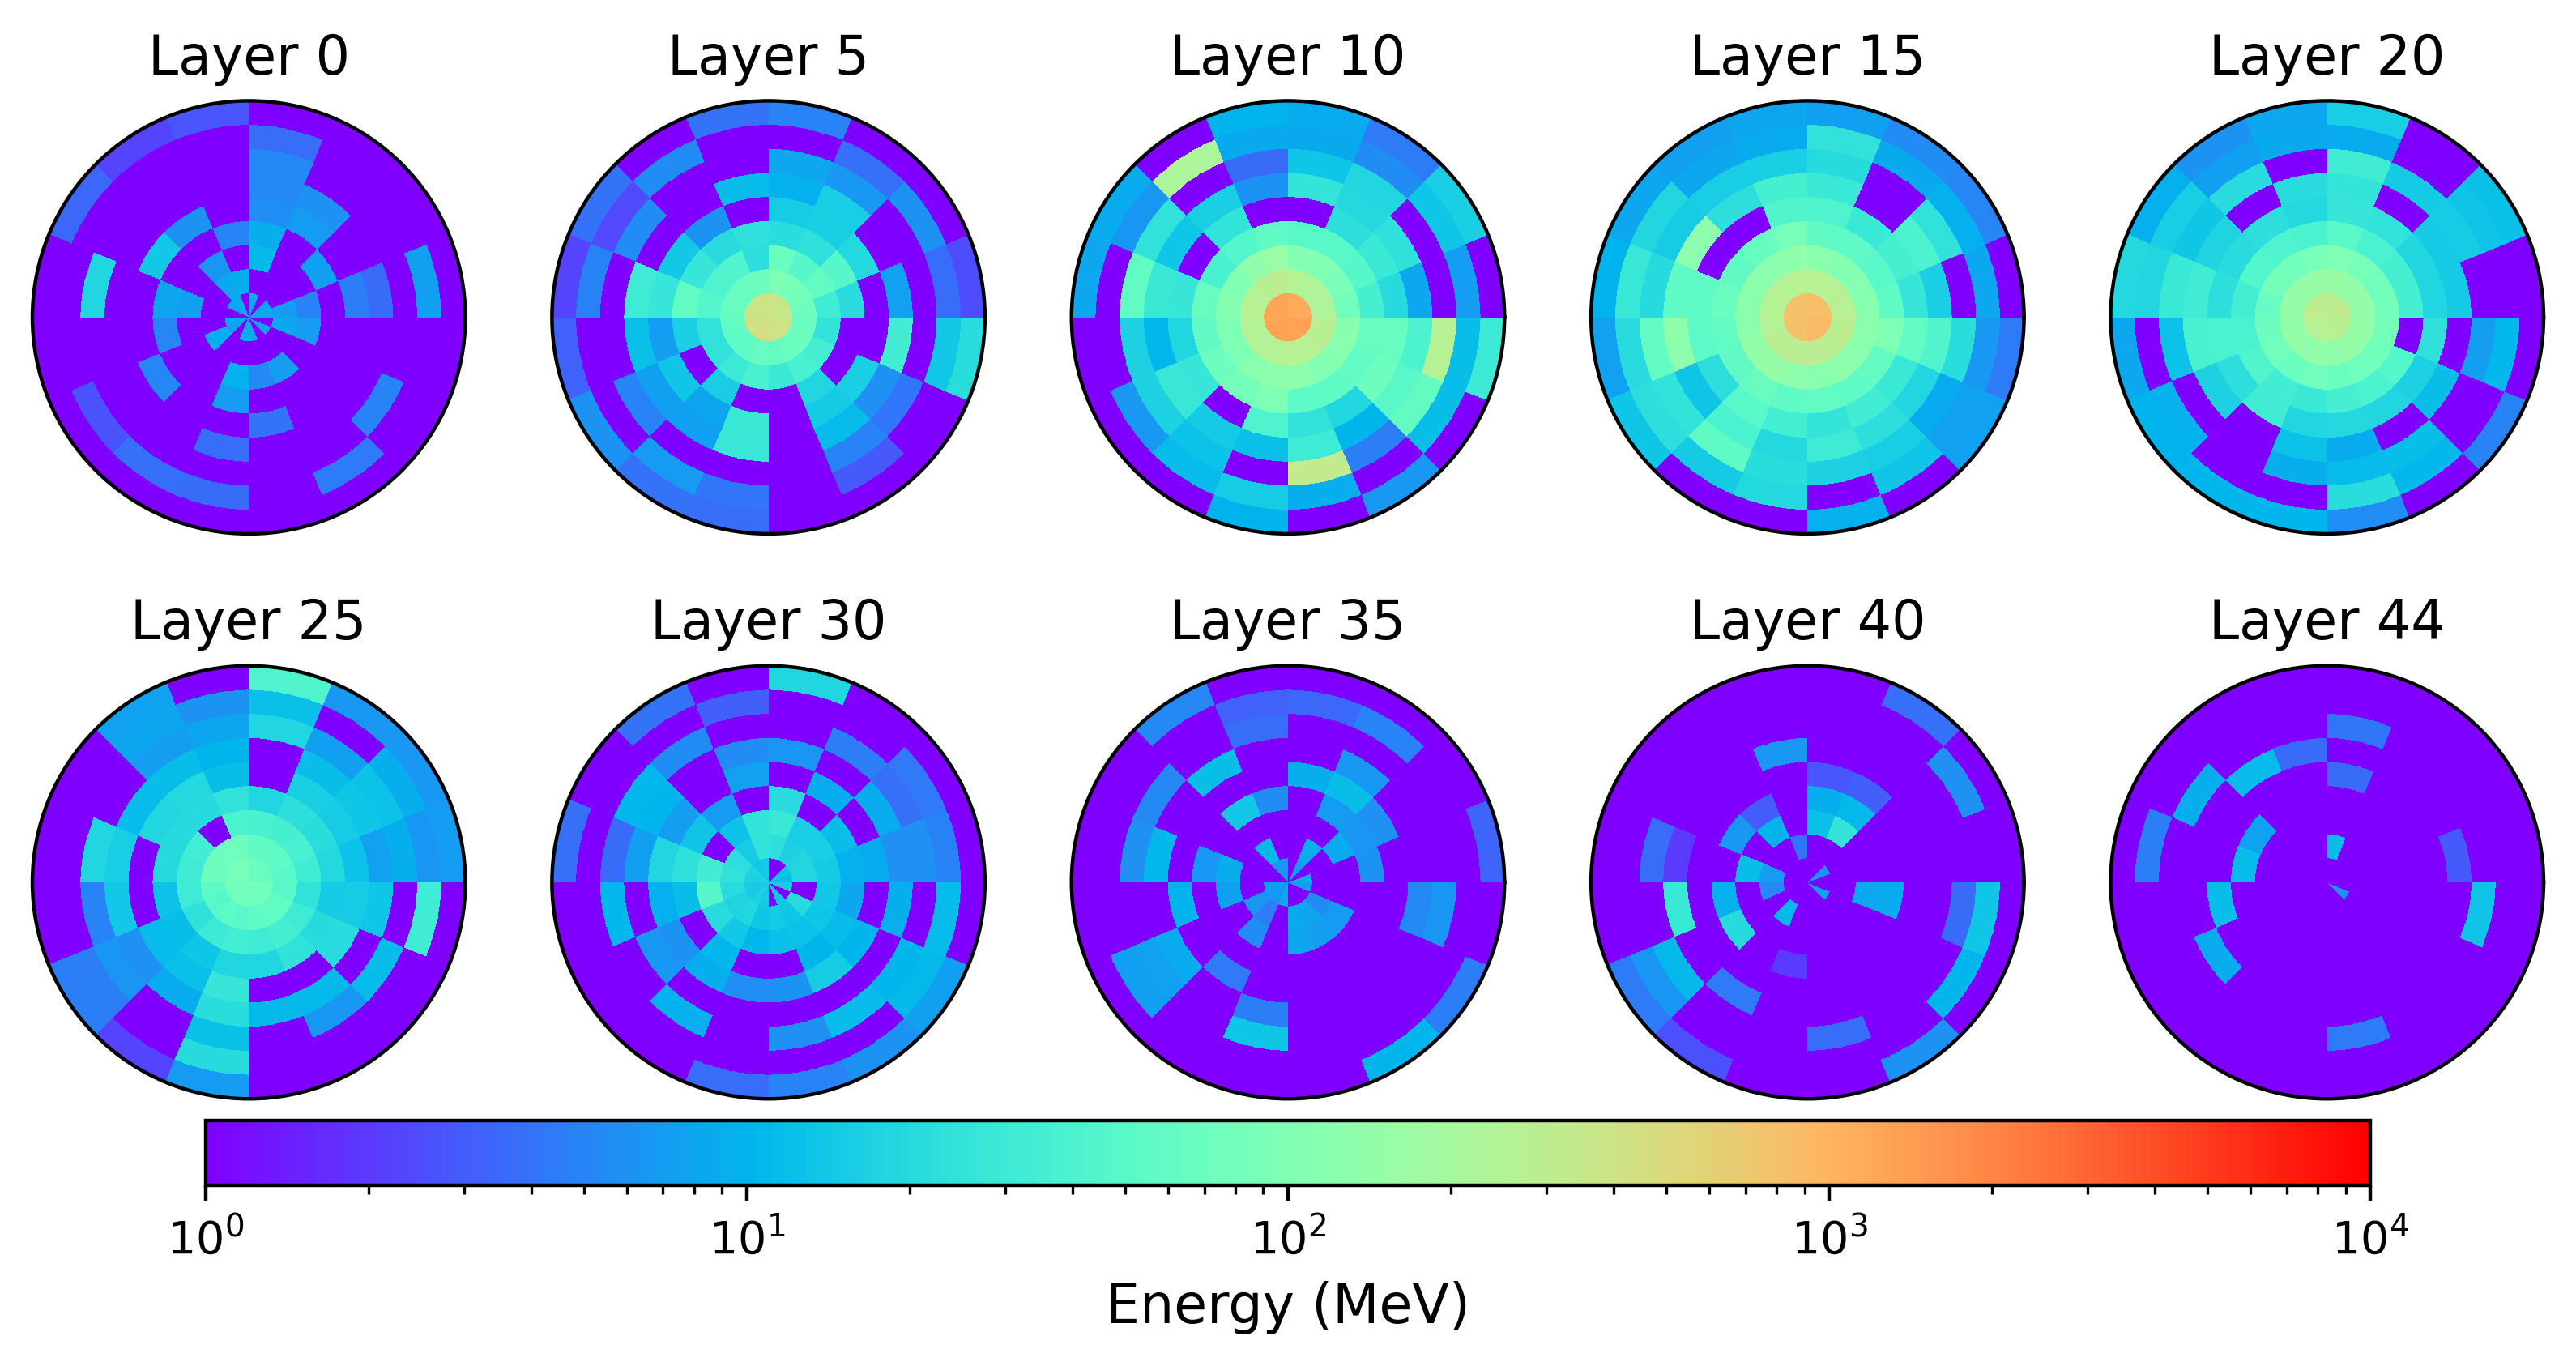

In [24]:
idx= 8000
HLF_1_electron.DrawSingleShower(xtarget_samples[idx,:].detach().cpu().numpy(), vmax=1e+4, vmin=1e0, cmap='rainbow')
HLF_1_electron.DrawSingleShower(xrecon_samples[idx,:].detach().cpu().numpy(), vmax=1e+4, vmin=1e0, cmap='rainbow') 
HLF_1_electron.DrawSingleShower(xgen_samples[idx,:].detach().cpu().numpy(), vmax=1e+4, vmin=1e0, cmap='rainbow') 

In [25]:
# data = np.linspace(0, 1, 256).reshape(1, 256)

# # 绘制颜色条
# plt.imshow(data, aspect='auto', cmap='rainbow')
# plt.colorbar()
# plt.show()

In [26]:
torch.log(torch.max(xtarget_samples))

tensor(8.3090)

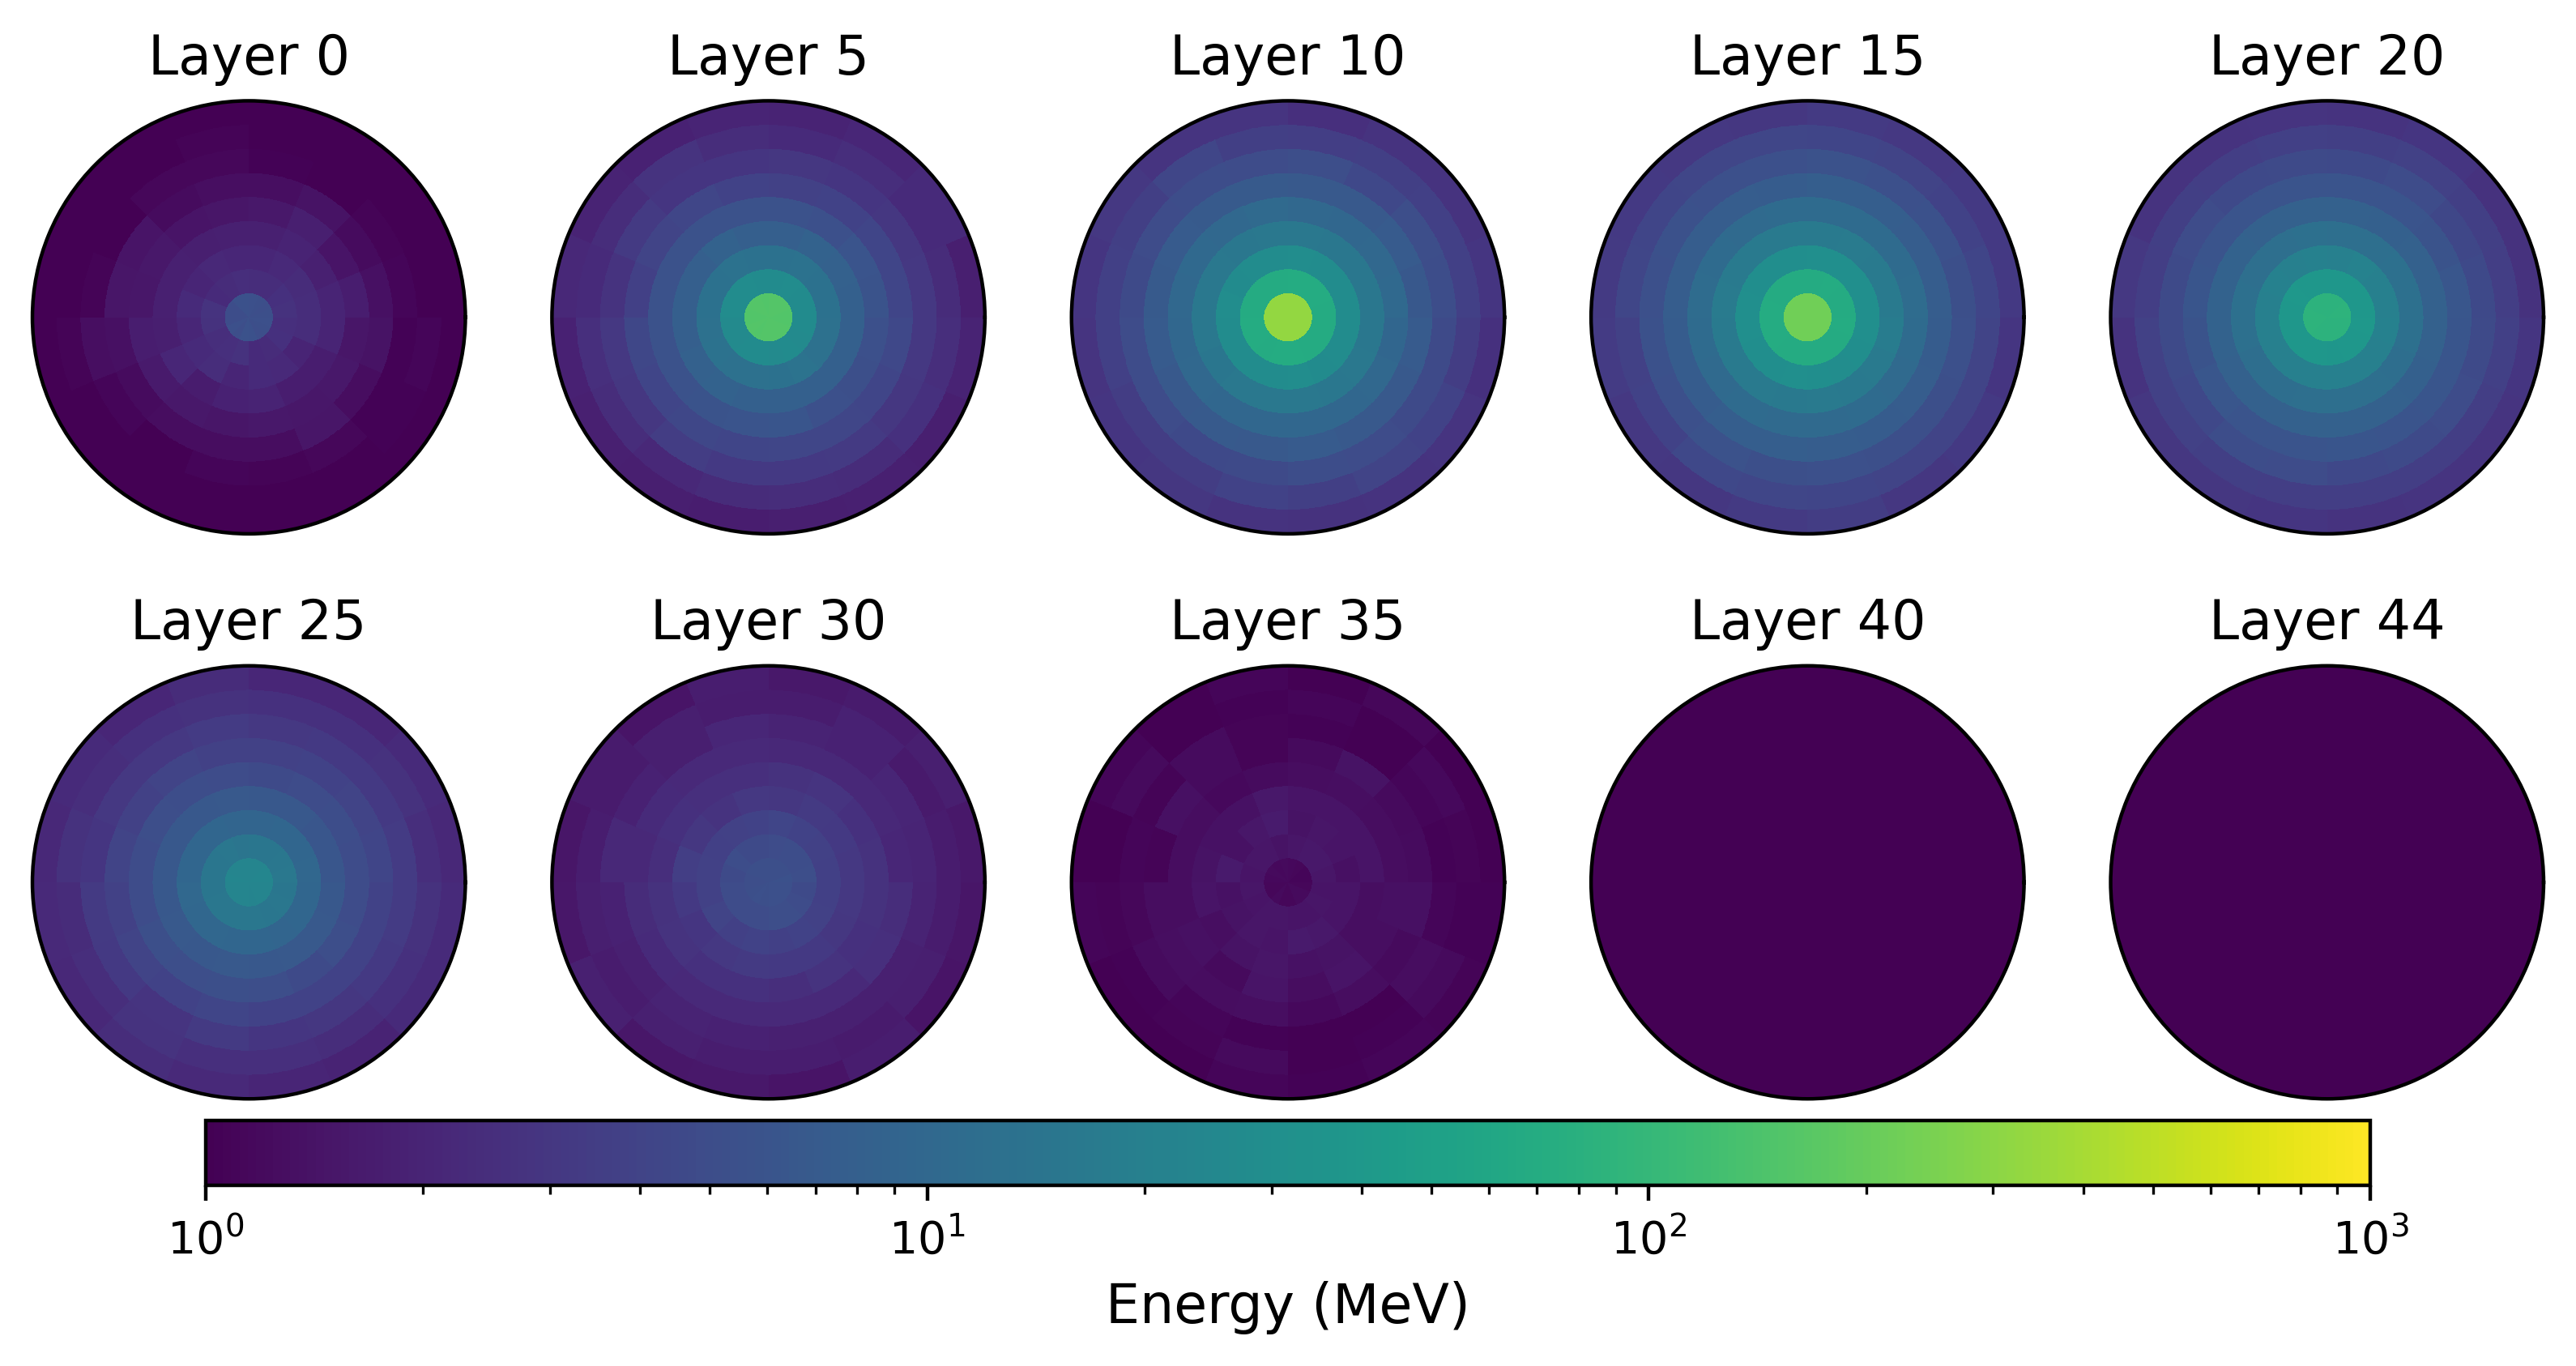

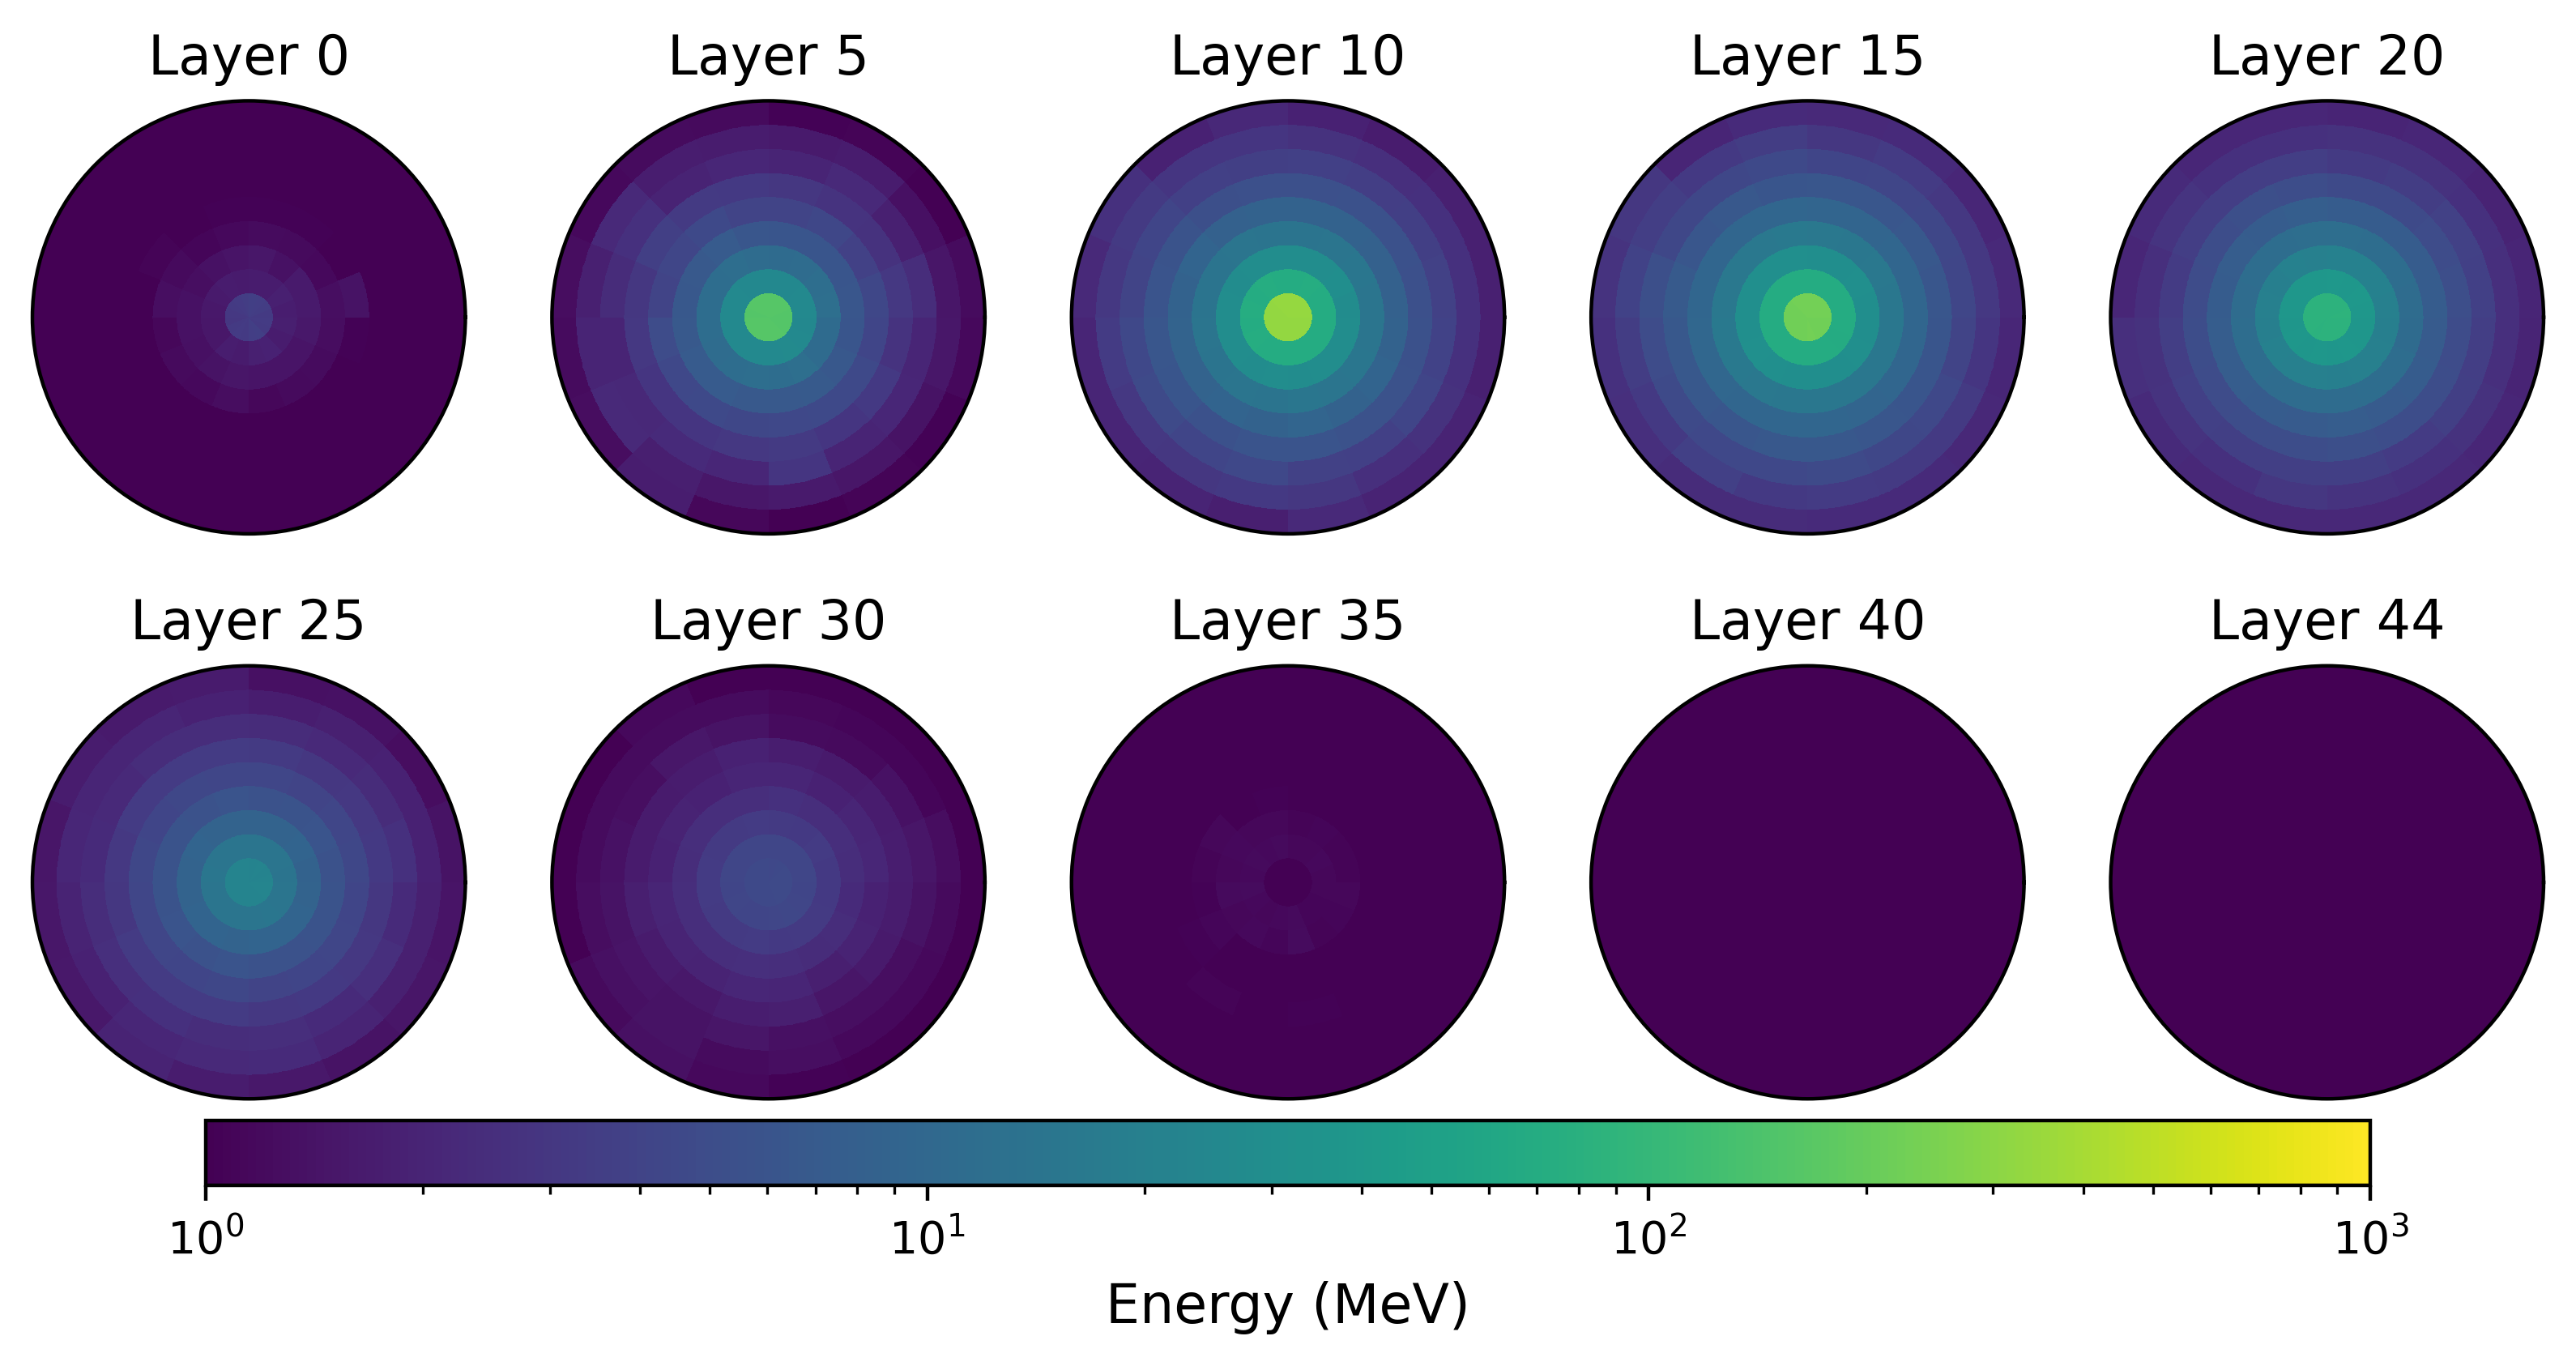

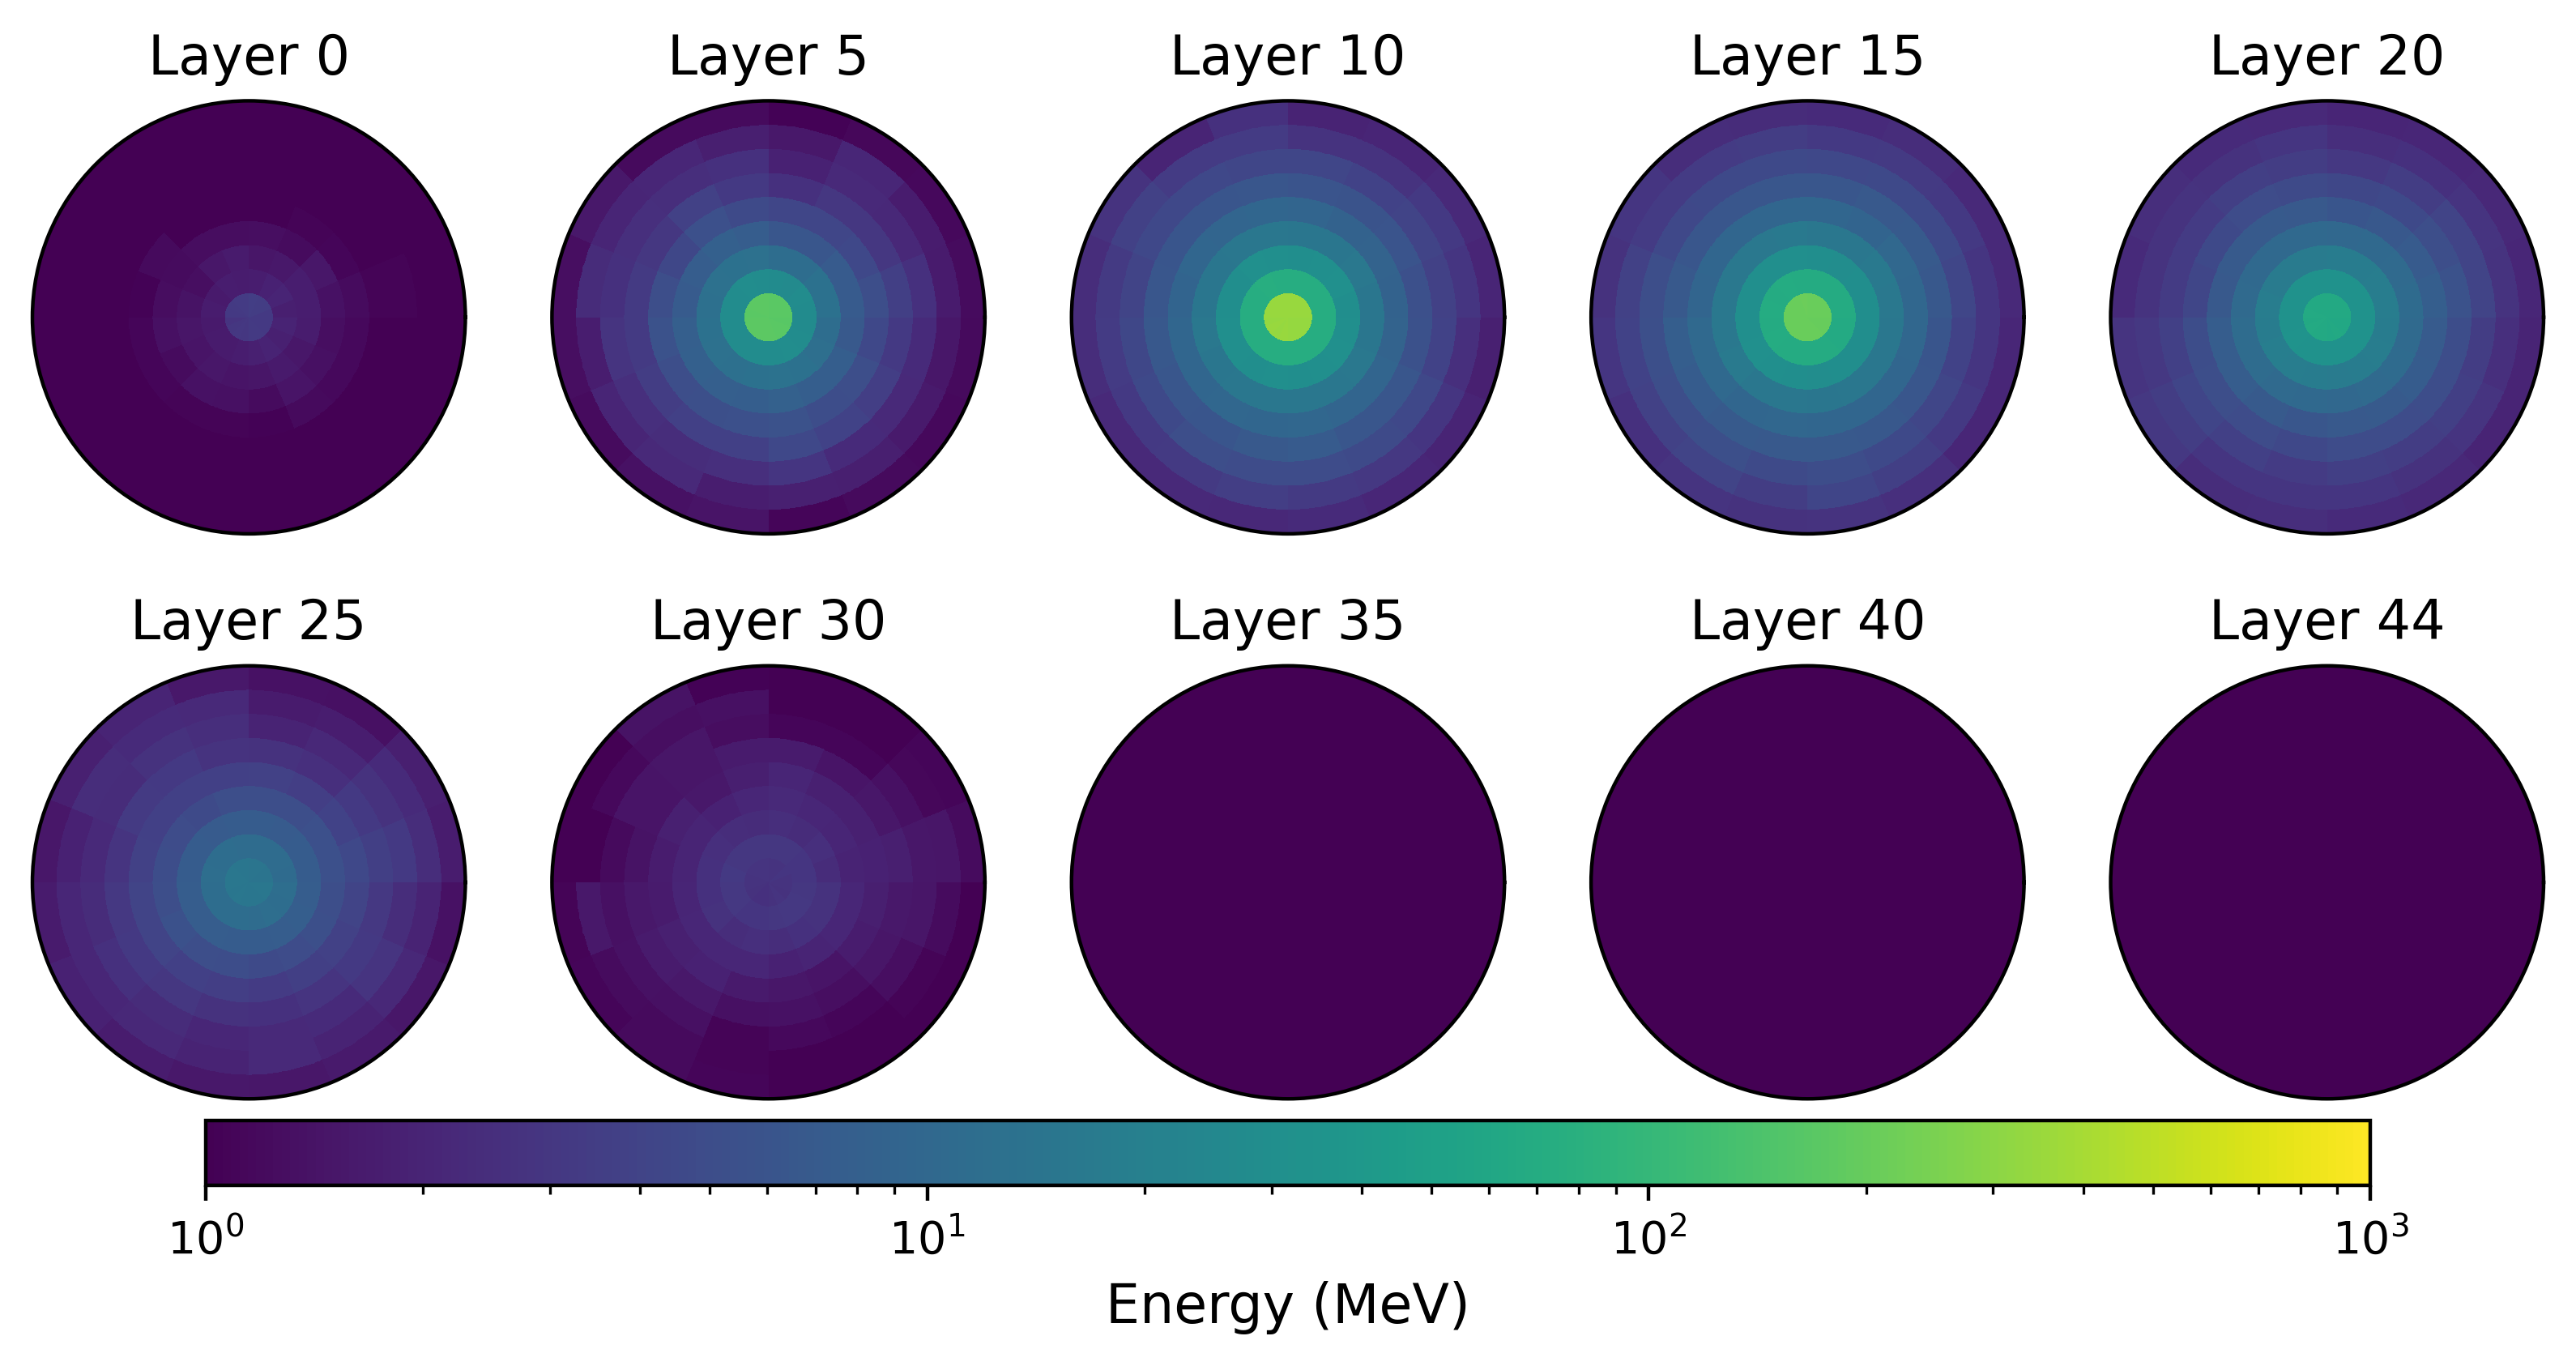

In [27]:
xtarget_mean = xtarget_samples.mean(dim=0)
xrecon_mean = xrecon_samples.mean(dim=0)
xgen_mean = xgen_samples.mean(dim=0)
HLF_1_electron.DrawSingleShower(xtarget_mean.detach().cpu().numpy(), vmax=1e+3, vmin=1e0)
HLF_1_electron.DrawSingleShower(xrecon_mean.detach().cpu().numpy(), vmax=1e+3, vmin=1e0)
HLF_1_electron.DrawSingleShower(xgen_mean.detach().cpu().numpy(), vmax=1e+3, vmin=1e0) 

In [28]:
# E_right = 60000
# E_left = 30000
# tmp = (entarget_samples < E_right) * (entarget_samples > E_left)
# idxEnFilter = (tmp == True).nonzero(as_tuple=True)[0]
# len(idxEnFilter)

# minVal, maxVal = min((xtarget_samples[idxEnFilter,:].sum(dim=1)/entarget_samples[idxEnFilter].view(-1)).numpy()), max((xtarget_samples[idxEnFilter,:].sum(dim=1)/entarget_samples[idxEnFilter].view(-1)).numpy())
# binwidth = (maxVal-minVal)/50
# plt.hist((xtarget_samples[idxEnFilter,:].sum(dim=1)/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, density=True, label="GT")
# plt.hist((xrecon_samples[idxEnFilter,:].sum(dim=1).numpy()/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c", density=True, label="Recon")
# plt.hist((xgen_samples[idxEnFilter,:].sum(dim=1).numpy()/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot", density=True, label="MC")


# plt.xlabel("Energy ratio", fontsize=15)
# # plt.xscale('log')

# plt.ylabel("Histogram", fontsize=15)
# # plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=18)
# plt.legend(fontsize=14, loc='upper left')
# # plt.title(f'{ds[part]} \n {E_left/1000}<E_inc<{E_right/1000} (GeV)')
# # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_ration_{modelname}_{arch}_{datascaled}_{part}.png')
# plt.show()

In [29]:
# torch.save(xtarget_samples, 'xtarget_samples.pt')
# torch.save(xrecon_samples, 'xrecon_samples.pt')
# torch.save(xgen_samples, 'xgen_samples.pt')
# torch.save(entarget_samples, 'entarget_samples.pt')

In [30]:
def measure_stochastic_granularity(data_tensor):
    segment_length = 144  # Length of each segment
    num_segments = 45     # Number of segments per sample
    num_samples = data_tensor.size(0)  # Number of samples in the data tensor

    # Use PyTorch to generate a random integer array of shape (num_samples,) with values between 0 and 15
    random_array = torch.randint(0, 16, (num_samples,), dtype=torch.int64, device=data_tensor.device)

    # Multiply random_array by 9 and expand it to shape (num_samples, num_segments)
    shifts = (random_array * 9).unsqueeze(-1).expand(-1, num_segments)

    # Unfold the data tensor to create segments of length 144
    # The result is a tensor of shape (num_samples, num_segments, segment_length)
    segments = data_tensor.unfold(1, segment_length, segment_length)

    # Create an indices tensor of shape (num_samples, num_segments, segment_length)
    indices = torch.arange(segment_length, device=data_tensor.device).repeat(num_samples, num_segments, 1)
    # Adjust the indices by adding the shifts and applying modulo operation to wrap around
    indices = (indices + shifts.unsqueeze(-1)) % segment_length  # Ensure correct broadcasting

    # Gather elements from the segments tensor using the adjusted indices
    rotated_segments = torch.gather(segments, 2, indices)

    # Reshape the rotated_segments tensor back to the original shape of data_tensor
    result_tensor = rotated_segments.view(num_samples, -1)

    # Compute the difference between the original data tensor and the result tensor
    diffs = data_tensor - result_tensor

    return diffs  

def measure_granularity(data_tensor, shift_index = 0):
    segment_length = 144  # Length of each segment
    num_segments = 45     # Number of segments per sample
    num_samples = data_tensor.size(0)  # Number of samples in the data tensor

    shifts = torch.full((num_samples,), shift_index, dtype=torch.int64, device=data_tensor.device).unsqueeze(-1).expand(-1, num_segments)

    # The result is a tensor of shape (num_samples, num_segments, segment_length)
    segments = data_tensor.unfold(1, segment_length, segment_length)

    # Create an indices tensor of shape (num_samples, num_segments, segment_length)
    indices = torch.arange(segment_length, device=data_tensor.device).repeat(num_samples, num_segments, 1)
    # Adjust the indices by adding the shifts and applying modulo operation to wrap around
    indices = (indices + shifts.unsqueeze(-1)) % segment_length  # Ensure correct broadcasting

    # Gather elements from the segments tensor using the adjusted indices
    rotated_segments = torch.gather(segments, 2, indices)

    # Reshape the rotated_segments tensor back to the original shape of data_tensor
    result_tensor = rotated_segments.view(num_samples, -1)

    # Compute the difference between the original data tensor and the result tensor
    diffs = data_tensor - result_tensor

    return diffs

In [31]:
def _reduce(in_data, true_energy, R=1e-7):
        return torch.log(1+in_data)

def _reduceinv(in_data, true_energy, R=1e-7):
        return torch.exp(in_data) - 1

In [32]:
reduced_target = _reduce(xtarget_samples, entarget_samples)
# / extended_layer_mask_matrix
reduced_gen = _reduce(xrecon_samples, entarget_samples)
# / extended_layer_mask_matrix

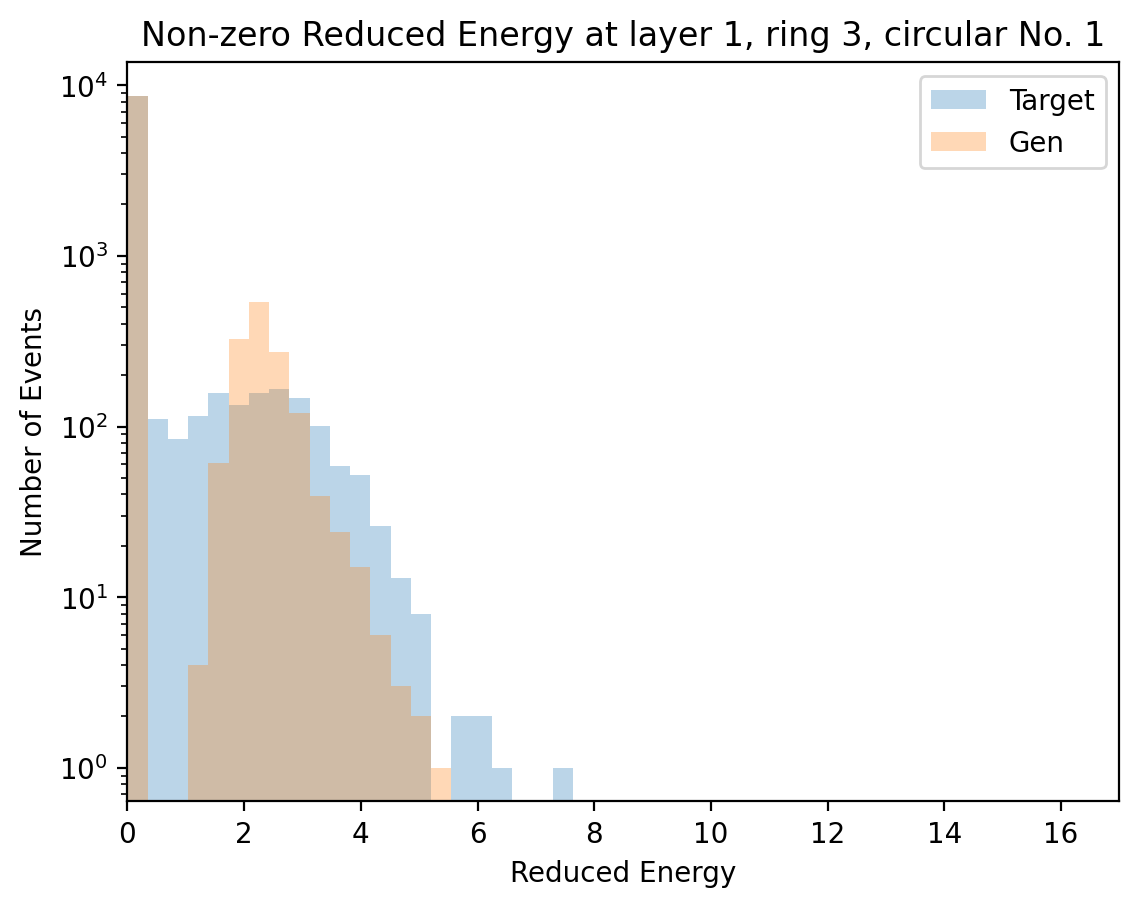

In [37]:
n_layer = 1
n_ring = 3
n_s = 1
voxel_index = (n_layer - 1) * 144 + (n_ring - 1) + (n_s - 1) * 9 
target_voxel = reduced_target[:,voxel_index]
gen_3d_nHD_voxel = reduced_gen[:,voxel_index]
non_zero_values_target = target_voxel[target_voxel > -10].numpy()
non_zero_values_gen_3d_nHD = gen_3d_nHD_voxel[gen_3d_nHD_voxel > -10].numpy()

#unify the bins
n_bins = 50
lim = [0, 17]
combined_bins = np.linspace(lim[0], lim[1], n_bins)  # 分成 50 份，需要 51 个边界点
# combined_bins_upper = max(max(non_zero_values_taregt), max(non_zero_values_gen_3d_nHD))
# combined_bins_lower = min(min(non_zero_values_taregt), min(non_zero_values_gen_3d_nHD))
# combined_bins = np.linspace(combined_bins_lower, combined_bins_upper, 100)
plt.hist(non_zero_values_target, label='Target', alpha=0.3, bins=combined_bins, density= False)
plt.hist(non_zero_values_gen_3d_nHD, label='Gen', alpha=0.3, bins=combined_bins,density= False)
# plt.hist(non_zero_values_gen_3d_HD, label='3D with HD', alpha=0.3, bins=combined_bins,density= True)
plt.title(f'Non-zero Reduced Energy at layer {n_layer}, ring {n_ring}, circular No. {n_s}')
plt.xlabel('Reduced Energy')
plt.ylabel('Number of Events')
plt.yscale('log')
plt.xlim(lim[0], lim[1])
# plt.ylim(0, 0.16)
plt.legend()
plt.show()

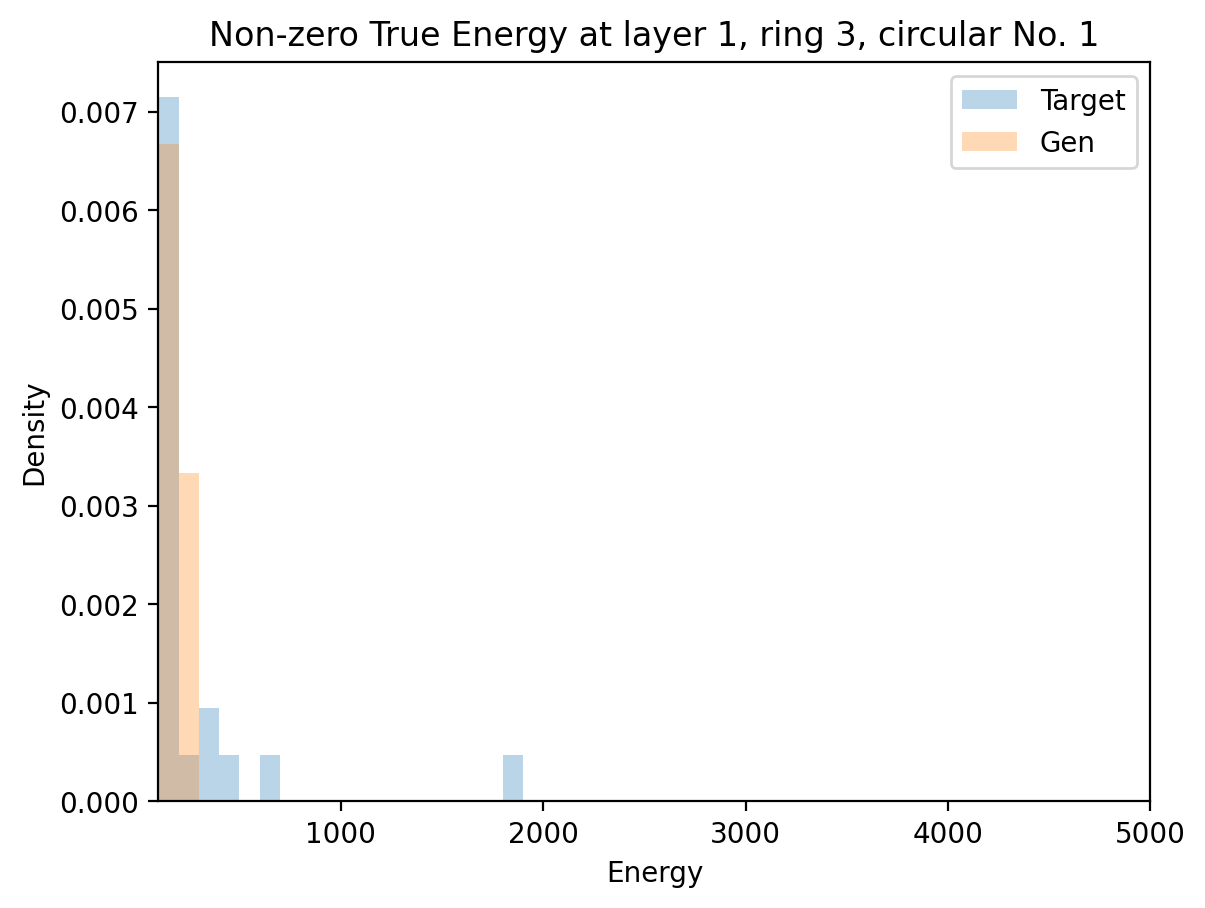

In [38]:
# n_layer = 6
# n_ring = 3
# n_s = 4
voxel_index = (n_layer - 1) * 144 + (n_ring - 1) + (n_s - 1) * 9 
target_voxel = xtarget_samples[:,voxel_index]
gen_3d_nHD_voxel = xrecon_samples[:,voxel_index]

non_zero_values_target = target_voxel[target_voxel != 0].numpy()
non_zero_values_gen_3d_nHD = gen_3d_nHD_voxel[gen_3d_nHD_voxel != 0].numpy()

#unify the bins
n_bins = 50
lim = [100,5000]
combined_bins = np.linspace(lim[0], lim[1], n_bins)  # 分成 50 份，需要 51 个边界点
# combined_bins_upper = max(max(non_zero_values_target), max(non_zero_values_gen_3d_nHD))
# combined_bins_lower = min(min(non_zero_values_target), min(non_zero_values_gen_3d_nHD))
# combined_bins = np.linspace(combined_bins_lower, combined_bins_upper, 100)
plt.hist(non_zero_values_target, label='Target', alpha=0.3, bins=combined_bins, density= True)
plt.hist(non_zero_values_gen_3d_nHD, label='Gen', alpha=0.3, bins=combined_bins,density= True)
# plt.hist(non_zero_values_gen_3d_HD, label='3D with HD', alpha=0.3, bins=combined_bins,density= True)
plt.title(f'Non-zero True Energy at layer {n_layer}, ring {n_ring}, circular No. {n_s}')
plt.xlabel('Energy')
plt.ylabel('Density')
# plt.yscale('log')
plt.xlim(lim[0], lim[1])
# plt.ylim(0, 0.16)
plt.legend()
plt.show()